# EDA a partir de la API de MELI
### Parte II: algoritmo predictivo
<a id="top"></a>
Autor: Mathiews Flores Zavala

<p> En esta notebook, voy a explorar los resultados de las publicaciones de MELI meduante su API de acceso público, que se vio en la Parte I (ver en el<a href = 'https://github.com/Mattzvl/EDA_API_ML'> EDA_API_MELI </a> para mas detalles).</p>
<p><strong>Objetivo:</strong> Implementar un algoritmo predictivo para poder predecir las unidades vendidas <i>sold_quantity</i></p>

## Tabla de Contenidos
1. <a href="#1">Data Wrangling</a>
* 1.1 <a href="#1.1">Importando librerías y datos</a>
* 1.2 <a href="#1.2">Exploramos el Data Set </a>
* 1.3 <a href="#1.3">Limpieza del data set: columnas, duplicados y valores NaN</a>
* 1.4 <a href="#1.4">Outliers</a>
* 1.5 <a href="#1.5">Visualización</a>
* 1.6 <a href="#1.6">Feature Engineering</a>
* 1.7 <a href="#1.6">Feature Selection</a>

2. <a href="#2">Preproceso de datos</a>
* 2.1 <a href='#2.1'>Preparacion de los datos</a>
* 2.2 <a href='#2.2'>Separación de datos en Train y Test</a>
* 2.3 <a href='#2.3'> Vectorizamos con Tf_idf</a>
* 2.4 <a href='#2.4'>Encoding de variables categóricas</a>
* 2.5 <a href='#2.5'>Standarización de variables numéricas</a>
* 2.6 <a href='#2.6'>Features de Train y Test</a>

3. <a href="#3">Modelos de Predicción</a>
* 3.1 <a href='#3.1'>Stats Model</a>
    * 3.1.1 <a href='#3.1.1'>Regresión Lineal</a> 
    * 3.1.2 <a href='#3.1.2'>Regresión Lineal con Feature Selection</a> 
    * 3.1.3 <a href='#3.1.3'>VIF</a> 
    * 3.1.4 <a href='#3.1.4'>RFE</a> 
* 3.2 <a href='#3.2'>CatBoost</a>

4. <a href="#4">Conclusiones</a>



---
<a href="#top">Back to Index</a>
<a id="1"></a>
### 1) Data Wrangling
<a id="1.1"></a>
#### 1.1) Importando librerias y datos

In [1]:
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from time import time, sleep
import re

import warnings
warnings.filterwarnings('ignore')
from bs4 import BeautifulSoup
import unidecode
from nltk.corpus import stopwords 


# Librerias de Machine Learning
from sklearn import preprocessing, metrics, linear_model
from sklearn.metrics import accuracy_score,confusion_matrix, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer,TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import RFECV

from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from catboost import CatBoostRegressor

Consulto la API de Mercado Libre publica mediante búsquedas. En esta instacia me focalizaré en recopilar datos para componer una muestra de la población de publicaciones disponibles de la API de MELI

In [2]:
data = pd.read_csv('./data/data_part1.csv')
data.head()

,id,site_id,title,price,prices,sale_price,currency_id,available_quantity,sold_quantity,buying_mode,...,neutral,claims,delayed_handling_time,sales,cancellations,free_shipping,mode,tags.2,logistic_type,store_pick_up
0,MLA898264823,MLA,Smart Tv Tcl 50p8m Led 4k 50,54999.0,"{'id': 'MLA898264823', 'prices': [{'id': '16',...",NaN,ARS,1,121,buy_it_now,...,0.02,"{'rate': 0.0148, 'value': 185, 'period': '60 d...","{'rate': 0.0152, 'value': 181, 'period': '60 d...","{'period': '60 days', 'completed': 11792}","{'rate': 0.003, 'value': 38, 'period': '60 days'}",True,me2,"['mandatory_free_shipping', 'self_service_in']",cross_docking,False
1,MLA905996538,MLA,Smart Tv Hyundai 50 4k Uhd Google Android,49999.0,"{'id': 'MLA905996538', 'prices': [{'id': '139'...",NaN,ARS,1,250,buy_it_now,...,0.01,"{'rate': 0.0084, 'value': 1109, 'period': '60 ...","{'rate': 0, 'value': 0, 'period': '60 days'}","{'period': '60 days', 'completed': 125242}","{'rate': 0, 'value': 0, 'period': '60 days'}",True,me2,"['fulfillment', 'mandatory_free_shipping']",fulfillment,False
2,MLA898844422,MLA,Smart Tv Samsung Series 7 Un50tu7000gczb Led 4...,75999.0,"{'id': 'MLA898844422', 'prices': [{'id': '152'...",NaN,ARS,273,7388,buy_it_now,...,0.01,"{'rate': 0.0084, 'value': 1109, 'period': '60 ...","{'rate': 0, 'value': 0, 'period': '60 days'}","{'period': '60 days', 'completed': 125242}","{'rate': 0, 'value': 0, 'period': '60 days'}",True,me2,"['fulfillment', 'mandatory_free_shipping']",fulfillment,False
3,MLA933497704,MLA,Amazon Fire Tv Stick 4k De Voz 4k 8gb Negro...,10888.0,"{'id': 'MLA933497704', 'prices': [{'id': '1', ...",NaN,ARS,3,2,buy_it_now,...,0.01,"{'rate': 0, 'value': 1, 'period': '60 days'}","{'rate': 0, 'value': 0, 'period': '60 days'}","{'period': '60 days', 'completed': 2364}","{'rate': 0, 'value': 0, 'period': '60 days'}",True,me2,"['self_service_in', 'mandatory_free_shipping']",cross_docking,False
4,MLA926081002,MLA,Smart Tv Bgh 50 Uhd Android,66999.0,"{'id': 'MLA926081002', 'prices': [{'id': '37',...",NaN,ARS,250,250,buy_it_now,...,0.01,"{'rate': 0.0084, 'value': 1109, 'period': '60 ...","{'rate': 0, 'value': 0, 'period': '60 days'}","{'period': '60 days', 'completed': 125242}","{'rate': 0, 'value': 0, 'period': '60 days'}",True,me2,"['fulfillment', 'mandatory_free_shipping']",fulfillment,False


In [3]:
data.shape

(4160, 63)

La busqueda mediante la API de MELI se obtuvo un data set con 4160 registros focalizado principalmente elementos de eletronica como lo son televisores, telefonos, notebooks, tablets.

<a id="1.2"></a>
#### 1.2) Explorando el data set

In [4]:
# explioramos el data set de la parte 1
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4160 entries, 0 to 4159
Data columns (total 63 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4160 non-null   object 
 1   site_id                4160 non-null   object 
 2   title                  4160 non-null   object 
 3   price                  4160 non-null   float64
 4   prices                 4160 non-null   object 
 5   sale_price             0 non-null      float64
 6   currency_id            4160 non-null   object 
 7   available_quantity     4160 non-null   int64  
 8   sold_quantity          4160 non-null   int64  
 9   buying_mode            4160 non-null   object 
 10  listing_type_id        4160 non-null   object 
 11  stop_time              4160 non-null   object 
 12  condition              4160 non-null   object 
 13  permalink              4160 non-null   object 
 14  thumbnail              4160 non-null   object 
 15  thum

In [5]:
# veamos los valores númericos para conocer su comportamiento
data.describe()

,price,sale_price,available_quantity,sold_quantity,original_price,official_store_id,order_backend,id.1,total,canceled,completed,negative,positive,neutral
count,4.160000e+03,0.0,4160.000000,4160.000000,709.000000,621.000000,4160.000000,4.160000e+03,4160.000000,4160.000000,4160.000000,4160.000000,4160.000000,4160.000000
mean,7.448659e+04,NaN,156.363702,50.757212,75526.043554,1090.275362,25.497356,2.081767e+08,51226.624038,2776.597356,48450.026683,0.027495,0.947060,0.023281
std,3.707253e+05,NaN,1515.758183,343.723400,64331.915747,827.029270,14.431171,1.686220e+08,110814.910854,5546.391381,105340.620247,0.042096,0.098846,0.079299
min,3.300000e+01,NaN,1.000000,0.000000,1600.000000,47.000000,1.000000,1.048590e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.500000e+04,NaN,1.000000,1.000000,20899.000000,229.000000,13.000000,8.252185e+07,3235.000000,180.000000,3081.000000,0.010000,0.940000,0.010000
50%,4.995850e+04,NaN,1.000000,5.000000,59999.000000,1205.000000,25.500000,1.727533e+08,13374.000000,958.000000,12740.000000,0.020000,0.960000,0.020000
75%,9.310338e+04,NaN,3.000000,25.000000,109999.000000,1938.000000,38.000000,2.848246e+08,41854.000000,2303.000000,39757.000000,0.030000,0.980000,0.020000
max,2.335000e+07,NaN,50000.000000,10459.000000,395999.000000,2588.000000,50.000000,8.006795e+08,613410.000000,29023.000000,585075.000000,1.000000,1.000000,1.000000


En esta priemra instancia podemos observar que cirtos valores como *id.1, official_store_id, order_backend* no aportaran peso al modelo.
Por otro lado la columna *sale_price* se encuentra vacia.

 <a id="1.3"></a>
#### 1.3) Limpieza del data set: columnas, duplicados y valores NaN
En esta instancia se tratarán las columnas, valores duplicados y nulos.
Además, determinar que registros se conservarán (feature selection)

In [6]:
# eliminamos las columnas que consideramos no nos aportarán al modelo
data_clean = data.drop(['id.1', 'official_store_id', 'order_backend'],axis =1)

In [7]:
# conozco las columnas que posee y para referencia
columnas_ref =data_clean.columns

# exploro cuales son aquellas columnas que contienen id en su nombre y que pueden ser simplemente primaries o foreign keys
indices_col_ref = [pos for pos, element in enumerate(columnas_ref) if 'id' in element]
columnas_ref[indices_col_ref]

Index(['id', 'site_id', 'currency_id', 'listing_type_id', 'thumbnail_id',
       'category_id', 'domain_id', 'catalog_product_id', 'use_thumbnail_id',
       'state_id', 'city_id', 'level_id'],
      dtype='object')

In [8]:
# veamos el data set que contiene solamente columnas con la palabra id
data_clean[columnas_ref[indices_col_ref]]

,id,site_id,currency_id,listing_type_id,thumbnail_id,category_id,domain_id,catalog_product_id,use_thumbnail_id,state_id,city_id,level_id
0,MLA898264823,MLA,ARS,gold_special,849404-MLA45797322642_052021,MLA1002,MLA-TELEVISIONS,MLA15186500,True,AR-C,NaN,5_green
1,MLA905996538,MLA,ARS,gold_special,836204-MLA44728420590_012021,MLA1002,MLA-TELEVISIONS,MLA17849007,True,AR-B,NaN,5_green
2,MLA898844422,MLA,ARS,gold_pro,878604-MLA44160072739_112020,MLA1002,MLA-TELEVISIONS,MLA16233171,True,AR-B,NaN,5_green
3,MLA933497704,MLA,ARS,gold_special,700522-MLA46539887496_062021,MLA352001,MLA-STREAMING_MEDIA_DEVICES,MLA14141341,True,AR-C,NaN,5_green
4,MLA926081002,MLA,ARS,gold_pro,893006-MLA46430431526_062021,MLA1002,MLA-TELEVISIONS,NaN,True,AR-B,NaN,5_green
...,...,...,...,...,...,...,...,...,...,...,...,...
4155,MLA871820328,MLA,ARS,gold_pro,718399-MLA41642098919_052020,MLA1652,MLA-NOTEBOOKS,NaN,False,AR-C,TUxBQlZJTDQyMjBa,5_green
4156,MLA900496858,MLA,ARS,gold_pro,871478-MLA42424954747_062020,MLA1652,MLA-NOTEBOOKS,NaN,False,AR-C,TUxBQkJFTDcyNTJa,5_green
4157,MLA895870357,MLA,ARS,gold_pro,612018-MLA46887309472_072021,MLA1652,MLA-NOTEBOOKS,MLA17328361,False,AR-B,NaN,5_green
4158,MLA866181995,MLA,ARS,gold_special,698116-MLA46101176637_052021,MLA1652,MLA-NOTEBOOKS,MLA16053932,False,AR-C,TUxBQlNBTjgzMjRa,5_green


In [9]:
def cant_valores_unicos(df):
    '''Cuenta la cantidad de valores unicos que existen cada columna de un dataset y devuelve un diccionario'''
    columnas = df.columns
    rta = {}
    for col in columnas:
        rta[col] = len(df[col].value_counts())
    return rta

In [10]:
cant_valores_unicos( data_clean[columnas_ref[indices_col_ref]] )

{'id': 4152,
 'site_id': 1,
 'currency_id': 1,
 'listing_type_id': 2,
 'thumbnail_id': 3437,
 'category_id': 14,
 'domain_id': 11,
 'catalog_product_id': 1221,
 'use_thumbnail_id': 2,
 'state_id': 19,
 'city_id': 98,
 'level_id': 4}

Como se puede observar, solo hay valores únicos para *site_id, currency_id* por lo tanto dropeare estos ya que no aportaran sustancialmente algo al modelo. Esto tiene sentido ya que los valores de las busquedas a la API se realizaron mediante el sitio MLA, por consiguiente la moneda predominante debería ser PESOS ARS.

In [11]:
data_clean = data_clean.drop(['site_id', 'currency_id'],axis =1)

Ocurre algo similar con *state_id, city_id* donde al ya tener *state_name, y city_name* estas resultan redundantes para el análisis. Así que tambien serán dropeadas.

In [12]:
data_clean = data_clean.drop(['state_id', 'city_id'],axis =1)

Tratamiento de valores duplicados, existen valores duplicados? es decir que contengan exactamente la misma data en sus registros.

In [13]:
# tratamiento de duplicados
print('Hay {} registros duplicados'.format(data_clean.duplicated().sum() ))

# eliminamos los registros duplicados
data_clean.drop_duplicates(inplace = True, keep='last')

print('\nQuedan registros duplicados?', data.duplicated().any() )

Hay 8 registros duplicados

Quedan registros duplicados? False


Respecto de datos *id* de las publicaciones que actuarian como una llave para los registros. En este caso, la cantidad de registros únicos coincidecon la cantidad de registros duplicados.
Por otro lado, respecto de las miñiaturas *thumbnail_id, use_thumbnail_id* no serán incorporadas al modelo.

In [14]:
data_clean = data_clean.drop(['thumbnail_id', 'use_thumbnail_id'],axis =1)

La columna *category_id* esta estreñamente relacionada con *domain_id* por lo tanto mantendremos solamente *domain_id*, que se utilizó en una instancia anterior para poder analizar los datos por categorias.

In [15]:
data_clean = data_clean.drop(['category_id'],axis =1)

In [16]:
# volvamos a ver cuantas son las que columnas que conservamos
columnas_ref2 =data_clean.columns
indices_col_ref2 = [pos for pos, element in enumerate(columnas_ref2) if 'id' in element]
columnas_ref2[indices_col_ref2]

Index(['id', 'listing_type_id', 'domain_id', 'catalog_product_id', 'level_id'], dtype='object')

In [17]:
# level_id parece indicar, siendo redundante, el nivel donde verde es muy bueno y naranja no tan bueno, esto relacionado
# con la confiabilidad/reputacion del vendedor que se indica en el portal de mercado libre usando esta escala.
data_clean['level_id'].value_counts()

5_green          3996
3_yellow           48
2_orange           13
4_light_green       8
Name: level_id, dtype: int64

In [18]:
# veamos que pasa con listing_type, el tipo de cotizacion se puede ver que hay dos tipos de categoria
data_clean['listing_type_id'].value_counts()

gold_special    2823
gold_pro        1329
Name: listing_type_id, dtype: int64

Para esta instancia es claro denotar que hay información que puede ser redundante y a su vez equivalente a otras, la descripción de una publicación se conrresponde con el id, pero ofrece data que puede ser más sustancial.

Por otro lado, *catalog_product_id* es el producto que se publica, que puede ser común para varias publicaciones (estan correlacionadas)

In [19]:
data_clean = data_clean.drop(['catalog_product_id'],axis =1)

Concentremonos en los **valores nulos** que tenemos, como se vio anteriormente *sale_price* es la única columna con todos sus registros nulos.

In [20]:
data_clean = data_clean.drop(['sale_price'],axis =1)

<a id="1.4"></a>
#### 1.4) Eliminación de Outliers

En esta instancia se eliminaran ciertos outliers que pueden hacer ruido en el modelo, principalmente aquellos vistos en la Parte I (ver en el<a href = 'https://github.com/Mattzvl/EDA_API_ML'> EDA_API_MELI </a> para mas detalles).</p> En este caso se empezará por el precio

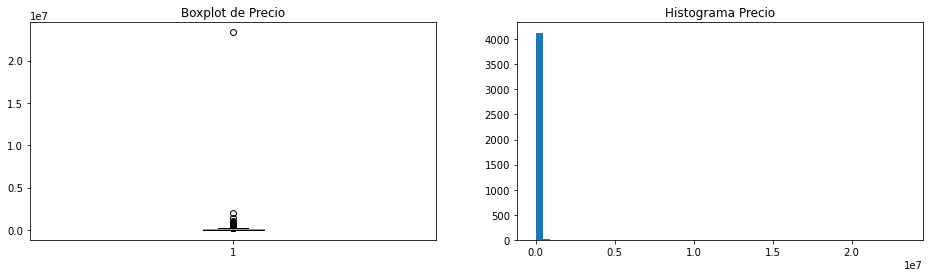

In [21]:
plt.figure(figsize = (16, 4))
ax = plt.subplot(1,2,1)
plt.boxplot(data=data_clean, x='price')
plt.title('Boxplot de Precio');

ax = plt.subplot(1,2,2)
plt.hist(data=data_clean, x='price', bins=50)
plt.title('Histograma Precio');

La forma del histograma hace recordar a los vistos en la parte 1, en particular para Tables y Televisores

In [22]:
# quitamos las  filas con distancias mayores a 1.5 + IQR
Q1_d, Q3_d = np.percentile(data_clean['price'], [25, 75])
IQR_d = Q3_d-Q1_d
lower_bound_d = Q1_d - (1.5 * IQR_d)
upper_bound_d = Q3_d + (1.5 * IQR_d)
# outlier_index = np.where((x < lower_bound) | (x > upper_bound))

# nos quedamos con las aquellos precios originales menores al quartil 3
data_clean2 = data_clean.loc[data_clean['price'] < upper_bound_d]

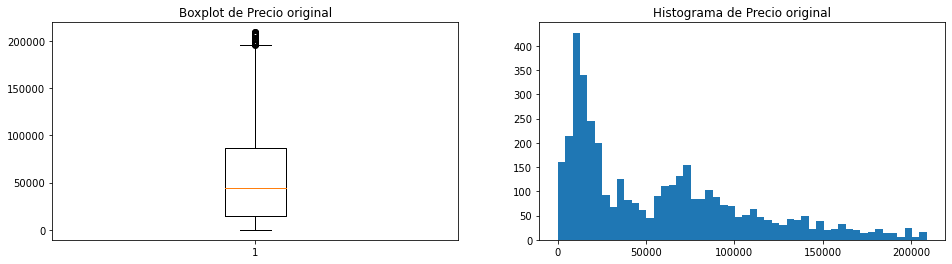

In [23]:
# veamos como resulto leugo de la eliminación de outlies
plt.figure(figsize = (16, 4))
ax = plt.subplot(1,2,1)
plt.boxplot(data=data_clean2, x='price')
plt.title('Boxplot de Precio original');

ax = plt.subplot(1,2,2)
plt.hist(data=data_clean2, x='price', bins=50)
plt.title('Histograma de Precio original');

Luego de la eliminación de Outliers se puede apreciar una distribución normal segada por la derecha, si bien siguen quedando algunos valores que estan algo por encima fuera del boxplot, los conservaremos apra el modelo.

<a id="1.5"></a>
#### 1.5) Visualizacion de datos

In [24]:
(data_clean2.groupby('domain_id')['original_price'].agg(['mean','median','std','max','min']).round(2)).sort_values(by = 'mean', ascending=False)

,mean,median,std,max,min
domain_id,,,,,
MLA-NOTEBOOKS,122142.01,115615.00,50866.68,264999.00,40137.00
MLA-TELEVISIONS,101763.52,87549.00,38669.40,225499.00,59999.00
MLA-CELLPHONES,31816.89,25644.50,26016.49,208999.00,4839.00
MLA-TABLETS,22917.85,18999.00,16502.70,145000.00,7999.00
MLA-STREAMING_MEDIA_DEVICES,11409.45,10749.00,4200.62,20000.00,7019.00
MLA-TV_RECEIVERS_AND_DECODERS,9999.00,9999.00,NaN,9999.00,9999.00
MLA-TV_AND_MONITOR_MOUNTS,6999.99,6999.99,NaN,6999.99,6999.99
MLA-AUDIO_AND_VIDEO_CABLES_AND_ADAPTERS,2818.00,2818.00,359.21,3072.00,2564.00
MLA-TV_REMOTE_CONTROL_COVERS,1600.00,1600.00,NaN,1600.00,1600.00


Las notebooks representan aquellos productos que tienen el mayor precio promedio (independientemente de la gama del articulo)
En tanto que las tablets tienen el menor precio medio.

Los valores máx quedaron mucho más coherentes, aunque hay casos donde el min de television, telefonos y tablet que son casi 2500 veces menores a la media, del orden de 1e-4.

Aquellos que tienen std = NaN, son aquellos elementos que son unicos, ya que temino dividinedo por 0 (n-1).
Estos son productos que se colaron el la busqueda de television, donde los resultados entregados no fueron tan precisos como con tablets, notebooks y celulares.

domain_id = ['MLA-ELECTRONIC_ACCESSORIES_AND_SPARE_PARTS', 'MLA-TV_RECEIVERS_AND_DECODERS', 'MLA-TV_REMOTE_CONTROL_COVERS']

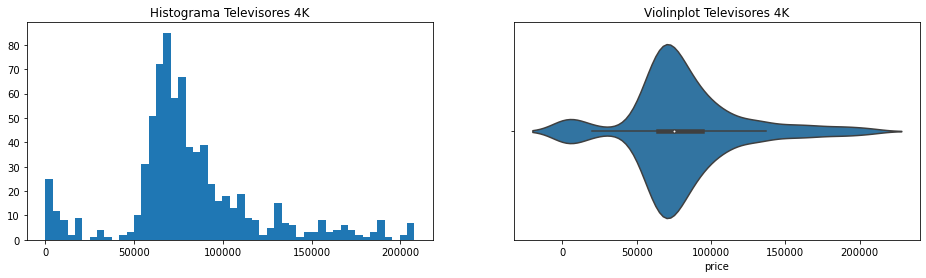

In [25]:
plt.figure(figsize = (16, 4))

ax = plt.subplot(1,2,1)
data_2plot = data_clean2[data_clean2['domain_id'] == 'MLA-TELEVISIONS']
plt.hist(data=data_2plot, x='price', bins=50)
plt.title('Histograma Televisores 4K')

ax = plt.subplot(1,2,2)
sns.violinplot(data=data_2plot, x='price', bins=10)
plt.title('Violinplot Televisores 4K')
plt.show()

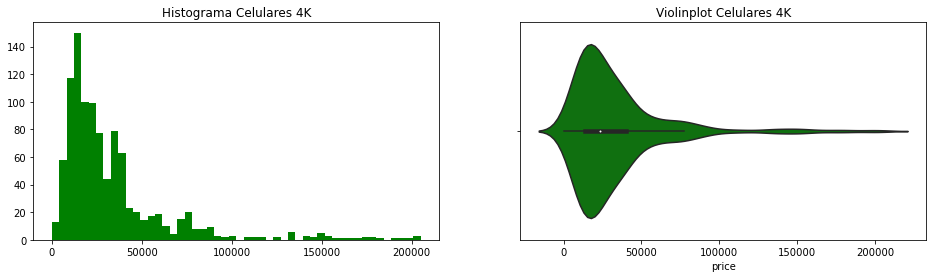

In [26]:
plt.figure(figsize = (16, 4))
ax = plt.subplot(1,2,1)
data_2plot = data_clean2[data_clean2['domain_id'] == 'MLA-CELLPHONES']
plt.hist(data=data_2plot, x='price', bins=50, color= 'green')
plt.title('Histograma Celulares 4K')

ax = plt.subplot(1,2,2)
sns.violinplot(data=data_2plot, x='price', bins=10, color= 'green')
plt.title('Violinplot Celulares 4K')
plt.show()

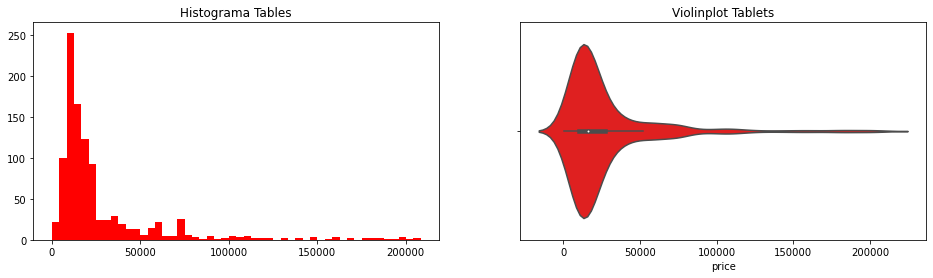

In [27]:
plt.figure(figsize = (16, 4))
ax = plt.subplot(1,2,1)
data_2plot = data_clean2[data_clean2['domain_id'] == 'MLA-TABLETS']
plt.hist(data=data_2plot, x='price', bins=50, color= 'red')
plt.title('Histograma Tables')

ax = plt.subplot(1,2,2)
sns.violinplot(data=data_2plot, x='price', bins=50, color= 'red')
plt.title('Violinplot Tablets')
plt.show()

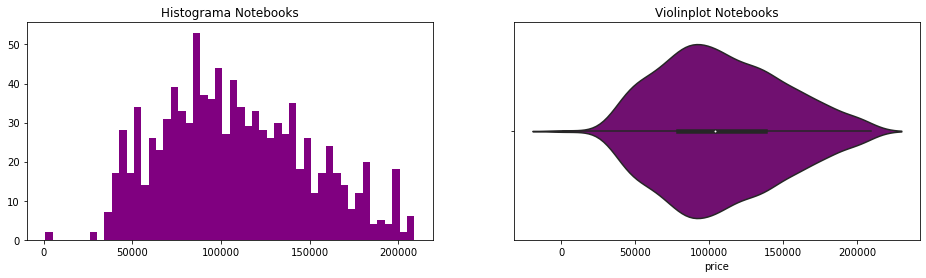

In [28]:
plt.figure(figsize = (16, 4))
ax = plt.subplot(1,2,1)
data_2plot = data_clean2[data_clean2['domain_id'] == 'MLA-NOTEBOOKS']
plt.hist(data=data_2plot, x='price', bins=50, color= 'purple')
plt.title('Histograma Notebooks')

ax = plt.subplot(1,2,2)
sns.violinplot(data=data_2plot, x='price', bins=50, color= 'purple')
plt.title('Violinplot Notebooks')
plt.show()

Los histogramas parecen distribuciones normales, la mayoria segadas hacia la izquierda (precios más bajos) al menos en televisores, celulares y tablets.

Se observa que hay ciertos datos anómalos al menos en la zona televisores que forman otro pico en uno de los extremos de la distribución, esto podría deberse a productos que tengan relación estrecha con televiosres, como controles, accesorios, sin embargo recibieron se etiquetaron con el *domain_id* que le corresponde a los televisores.

#### Estudio de correlaciones

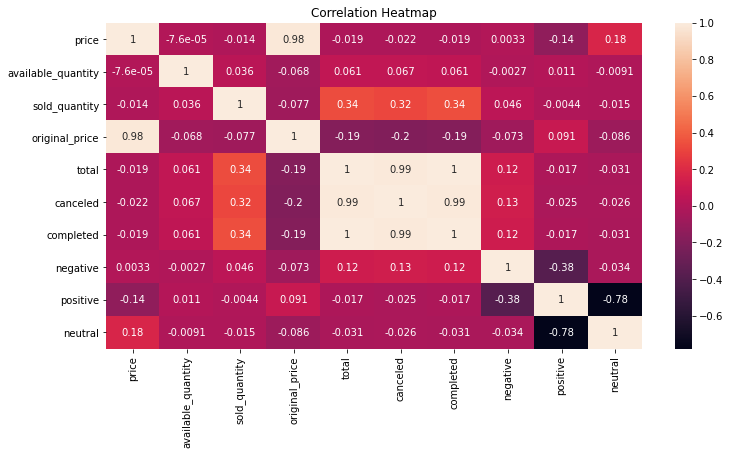

In [29]:
# graficamos un heatmap para exploras la relacion entre variables
plt.figure(figsize=(12,6))
# para no incorporar solamente aquellas variables numericas, ya que de lo contrario me tomaria los buleanos 
num_cols = [x for x in data_clean2.select_dtypes(include=['number']).columns]
sns.heatmap(data_clean[num_cols].corr(),annot=True)
plt.title("Correlation Heatmap")
plt.show()

De lo observado en el heat map, se puede ver que *sold_quantity* tiene relación poca correlación varios campos, la relación negativa de unidades vendidas con el precio, nos indicaría a priori que a mayor precio menos unidades vendidas.

Los aportes de cantidad de pedidos *total, canceled, completes* tienen practicamente el mismo aporte. Luego el rate *negative, positive, neutral* tienen un aporte cercano al cero. Lo mismo con *aviable_quantity*.

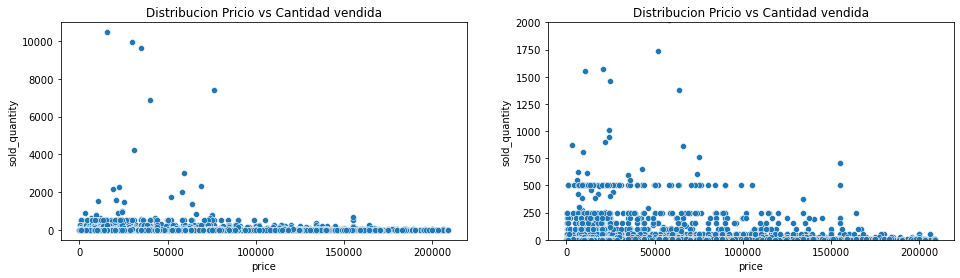

In [30]:
#Correlación entre cantidades vendidas y el precio
plt.figure(figsize = (16, 4))
data2plot1 = data_clean2.loc[:,['sold_quantity','price',]].copy()
ax = plt.subplot(1,2,1)
sns.scatterplot(data= data2plot1 ,x='price',y='sold_quantity')
plt.title('Distribucion Pricio vs Cantidad vendida');

ax = plt.subplot(1,2,2)
sns.scatterplot(data= data2plot1 ,x='price',y='sold_quantity')
plt.ylim(0, 2000)
plt.title('Distribucion Pricio vs Cantidad vendida');

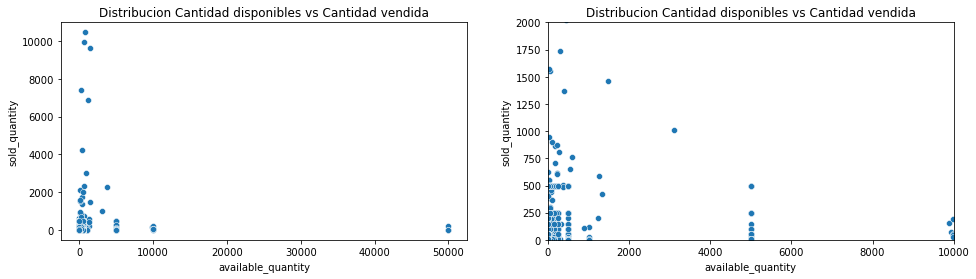

In [55]:
#Correlación entre cantidades vendidas y el precio
plt.figure(figsize = (16, 4))
data2plot1 = data_clean2.loc[:,['sold_quantity','available_quantity',]].copy()
ax = plt.subplot(1,2,1)
sns.scatterplot(data= data2plot1 ,x='available_quantity',y='sold_quantity')
plt.title('Distribucion Cantidad disponibles vs Cantidad vendida');

ax = plt.subplot(1,2,2)
sns.scatterplot(data= data2plot1 ,x='available_quantity',y='sold_quantity')
plt.ylim(0, 2000)
plt.xlim(0, 10000)
plt.title('Distribucion Cantidad disponibles vs Cantidad vendida');

<a id="1.6"></a>
#### 1.6) Feature Engineering

Respecto de los valores **nulos** de la columna *original_price*, aquellos registros con valores *nulls* corresponden a valores donde se aplica un descuento. Al ser *original_price* correlativa a *price*, voy a conservar price, sin embargo se generará un nuevo campo que represente el % de descuento.

In [31]:
data_clean2[['price','original_price']].sample(7)

,price,original_price
2394,20768.84,NaN
2424,16099.00,20129.0
2157,17089.00,NaN
1305,49900.00,NaN
643,3855.00,NaN
2724,196880.00,NaN
1387,39999.00,NaN


In [32]:
# completo los datos nulo de original_price con los valores de price
data_clean2['original_price'].fillna(data_clean2['price'], inplace = True)
#y verifico por si acaso
data_clean2['original_price'].isnull().sum()

0

In [33]:
# chequeo que no haya ningun valor de precio con valores = 0, es decir, Free!
data_clean2[data_clean2['original_price'] == 0]

,id,title,price,prices,available_quantity,sold_quantity,buying_mode,listing_type_id,stop_time,condition,...,neutral,claims,delayed_handling_time,sales,cancellations,free_shipping,mode,tags.2,logistic_type,store_pick_up


In [34]:
# creo una nueva columna donde indico el valor del descuento que se aplica en la publciacion
data_clean2['discount'] = 1 - data_clean2['price']/data_clean2['original_price']

Mas alla del ranking del usuario, la cantidad de ventas concretadas nos da una razon porcentual del éxito de sus ventas, aunque claro esta existen otros factores que también influyen en que no se concrete una venta.

Vamos a crear el *ranking_success* a partir de *completed / total*.

In [35]:
data_clean2['ranking_success'] = np.where(data_clean2['total']!= 0, data_clean2['completed']/data_clean2['total'], 0)

Datos unicos? para no tener un data set desbalanceado voy a eliminar aquellos casos donde solo haya un registro. Ya que hacer upper sampling implicaría simplemente en duplicar los registros únicos para las categorías de *domain_id*
donde solo tengo un valor.

In [36]:
# tipos de dominios, para identificar si la busqueda me devolvio efectivamente los cambos de las busquedas
data_clean2.domain_id.value_counts()

MLA-TABLETS                                   1022
MLA-CELLPHONES                                1017
MLA-NOTEBOOKS                                  990
MLA-TELEVISIONS                                751
MLA-STREAMING_MEDIA_DEVICES                    110
MLA-TV_REMOTE_CONTROLS                          48
MLA-AUDIO_AND_VIDEO_CABLES_AND_ADAPTERS         43
MLA-TV_AND_MONITOR_MOUNTS                        9
MLA-TV_RECEIVERS_AND_DECODERS                    1
MLA-ELECTRONIC_ACCESSORIES_AND_SPARE_PARTS       1
MLA-TV_REMOTE_CONTROL_COVERS                     1
Name: domain_id, dtype: int64

In [37]:
# tiramos aquellas clases de productos que aparezcan  menos de 2 veces
def remove_lonely_reg(data_reg, columna):
    '''Funcion que remueve registros que aparezcan  menos de 2 veces
    Se entrega un data set y la columna de interes, y se devuelve un data set'''
    return data_reg[~data_reg[columna].isin(data_reg[columna].value_counts().loc[lambda x: x < 3].index)]

data_clean3 = remove_lonely_reg(data_clean2, 'domain_id')
data_clean3.domain_id.value_counts()

MLA-TABLETS                                1022
MLA-CELLPHONES                             1017
MLA-NOTEBOOKS                               990
MLA-TELEVISIONS                             751
MLA-STREAMING_MEDIA_DEVICES                 110
MLA-TV_REMOTE_CONTROLS                       48
MLA-AUDIO_AND_VIDEO_CABLES_AND_ADAPTERS      43
MLA-TV_AND_MONITOR_MOUNTS                     9
Name: domain_id, dtype: int64

<a id="1.7"></a>
#### 1.7) Feature Selection

En esta instancia como continuacion de la limpieza, en lugar de dropear columnas que no considerare para el modelo, seleccionare aquellas que pasare al modelo final

In [38]:
data_clean3.to_excel('./data/data_clean3.xlsx', index= False)

In [39]:
data_clean3.columns

Index(['id', 'title', 'price', 'prices', 'available_quantity', 'sold_quantity',
       'buying_mode', 'listing_type_id', 'stop_time', 'condition', 'permalink',
       'thumbnail', 'accepts_mercadopago', 'installments', 'shipping',
       'seller_address', 'attributes', 'original_price', 'domain_id', 'tags',
       'catalog_listing', 'differential_pricing', 'permalink.1',
       'registration_date', 'car_dealer', 'real_estate_agency', 'tags.1',
       'eshop', 'seller_reputation', 'state_name', 'city_name',
       'power_seller_status', 'level_id', 'protection_end_date', 'real_level',
       'total', 'canceled', 'period', 'completed', 'negative', 'positive',
       'neutral', 'claims', 'delayed_handling_time', 'sales', 'cancellations',
       'free_shipping', 'mode', 'tags.2', 'logistic_type', 'store_pick_up',
       'discount', 'ranking_success'],
      dtype='object')

* *buying_mode* buy_it_now es el unico valor
* *accepts_mercadopago* VERDADERO es el unico valor
* *car_dealer* FALSO es el unico valor
* *real_estate_agency* FALSO es el unico valor
* *negative, positive, neutral* las 3 suman 1 por lo tanto solo podria considerar 2

In [40]:
data_m = data_clean3[['price','discount','available_quantity', 'sold_quantity','listing_type_id', 'condition','domain_id',\
                     'tags','state_name','city_name','power_seller_status','level_id','ranking_success',\
                      #'registration_date',\
                      'negative','positive','free_shipping','store_pick_up',   #]]
                      'id']]
data_m

,price,discount,available_quantity,sold_quantity,listing_type_id,condition,domain_id,tags,state_name,city_name,power_seller_status,level_id,ranking_success,negative,positive,free_shipping,store_pick_up,id
0,54999.0,0.0,1,121,gold_special,new,MLA-TELEVISIONS,"['loyalty_discount_eligible', 'brand_verified'...",Capital Federal,Once,platinum,5_green,0.942664,0.02,0.96,True,False,MLA898264823
1,49999.0,0.0,1,250,gold_special,new,MLA-TELEVISIONS,"['extended_warranty_eligible', 'good_quality_p...",Buenos Aires,Villa Celina,platinum,5_green,0.953807,0.06,0.93,True,False,MLA905996538
2,75999.0,0.0,273,7388,gold_pro,new,MLA-TELEVISIONS,"['ahora-12', 'brand_verified', 'extended_warra...",Buenos Aires,Villa Celina,platinum,5_green,0.953807,0.06,0.93,True,False,MLA898844422
3,10888.0,0.0,3,2,gold_special,new,MLA-STREAMING_MEDIA_DEVICES,"['good_quality_picture', 'good_quality_thumbna...",Capital Federal,CABA,platinum,5_green,0.961624,0.00,0.99,True,False,MLA933497704
4,66999.0,0.0,250,250,gold_pro,new,MLA-TELEVISIONS,"['ahora-12', 'catalog_product_candidate', 'ext...",Buenos Aires,Villa Celina,platinum,5_green,0.953807,0.06,0.93,True,False,MLA926081002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4154,59998.8,0.0,1,3,gold_special,new,MLA-NOTEBOOKS,"['extended_warranty_eligible', 'good_quality_p...",Buenos Aires,Ranelagh,platinum,5_green,0.922966,0.03,0.96,True,False,MLA923624121
4155,150985.0,0.0,1,5,gold_pro,new,MLA-NOTEBOOKS,"['brand_verified', 'extended_warranty_eligible...",Capital Federal,Villa Crespo,platinum,5_green,0.957775,0.01,0.97,True,False,MLA871820328
4157,159000.0,0.0,1,5,gold_pro,new,MLA-NOTEBOOKS,"['good_quality_picture', 'good_quality_thumbna...",Buenos Aires,Villa Bosch,gold,5_green,0.962629,0.03,0.97,True,False,MLA895870357
4158,83999.0,0.0,1,50,gold_special,new,MLA-NOTEBOOKS,"['good_quality_thumbnail', 'loyalty_discount_e...",Capital Federal,San Nicolás,platinum,5_green,0.963336,0.01,0.97,True,False,MLA866181995


In [41]:
# creamos una serie de funciones de limpieza
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_simbols(text):
    return re.sub(r'[^\w]', ' ', text)

def remove_numbers(text):
    return re.sub('(\d+)','',text)

def remove_linear(text):
    return re.sub('(\_+)',' ',text)

def denoise_text(text):
    text = strip_html(text)
    text = remove_simbols(text)
    text = remove_linear(text)
    text = remove_numbers(text)
    return text

In [42]:
# aplico al campo tags
data_m['tags']=data_m['tags'].apply(denoise_text)
data_m['tags']

0         loyalty discount eligible    brand verified ...
1         extended warranty eligible    good quality p...
2         ahora     brand verified    extended warrant...
3         good quality picture    good quality thumbna...
4         ahora     catalog product candidate    exten...
                              ...                        
4154      extended warranty eligible    good quality p...
4155      brand verified    extended warranty eligible...
4157      good quality picture    good quality thumbna...
4158      good quality thumbnail    loyalty discount e...
4159      brand verified    extended warranty eligible...
Name: tags, Length: 3990, dtype: object

In [43]:
# funcion que cuenta palabras clave en los tags de la publicacion
stop_words=stopwords.words('english') #la mayor parte de las palabras estan en ingles
vect=CountVectorizer(stop_words=stop_words,lowercase=True,strip_accents='unicode')

def words_freq(X):
    '''funcion que devuelve un dataframe con las palabras encontradas en un campo o serie y la cantidad que le corresponde'''
    X_enc=vect.fit_transform(X)    
    sum_words=X_enc.sum(axis=0)
    words_freq = sorted([(word, sum_words[0, idx]) for word, idx in  vect.vocabulary_.items()],reverse=False)
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    wf_df = pd.DataFrame(words_freq,columns=['word','quantity'])
        
    return wf_df

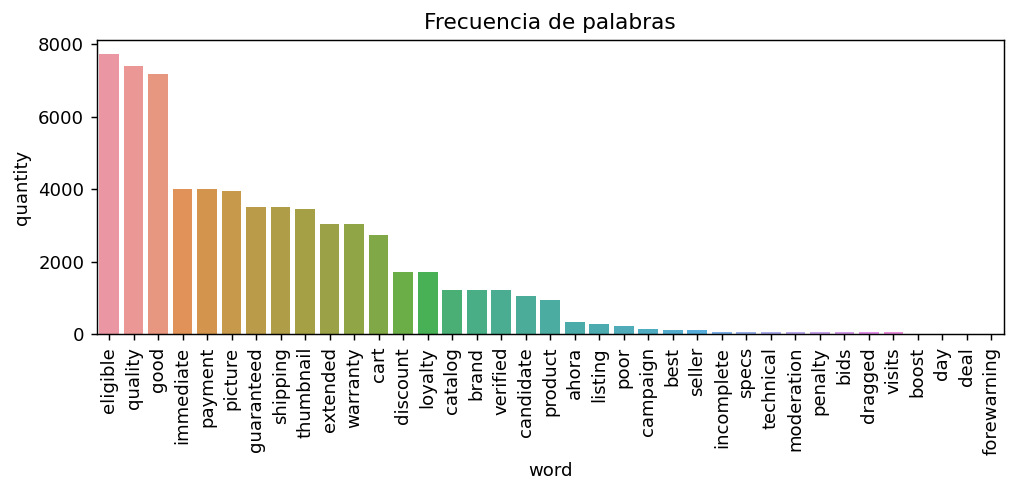

In [44]:
# Graficamos
words_cnt=words_freq(data_m.tags).head(75)
plt.figure(figsize=(9,3),dpi=130)
sns.barplot(data=words_cnt,x='word',y='quantity')
plt.title("Frecuencia de palabras")
plt.xticks(rotation=90);

In [45]:
words_cnt.head()

,word,quantity
0,eligible,7741
1,quality,7394
2,good,7178
3,immediate,3990
4,payment,3990


Como vemos las siguientes palabras son las *eligible, quality, good, immediate,	payment*

In [46]:
# token del metodo CountVectorizer
tokens=vect.get_feature_names()

In [47]:
# detecto palabras que no son reales, acorde al idioma que elegi
real_words=[]
wrong_words=[]
import enchant
from tqdm import tqdm 
spell=enchant.DictWithPWL("en_US")

for word in tqdm(tokens):
    if  spell.check(word):
        real_words.append(word)
    else:
        wrong_words.append(word)

stop_words_m = stopwords.words('english')
stop_words_m = text.ENGLISH_STOP_WORDS.union(wrong_words)

100%|████████████████████████████████████████████████████████████████████████████████| 37/37 [00:00<00:00, 1427.13it/s]


In [48]:
print('Existe/n {} palabras que no son validas en ingles'.format(len(wrong_words)))
print('Existe/n {} palabras que son validas en el ingles'.format(len(real_words)))

Existe/n 1 palabras que no son validas en ingles
Existe/n 36 palabras que son validas en el ingles


In [49]:
print('La palabra que no reconoce es precisamente "{}"'.format(wrong_words[0]))

La palabra que no reconoce es precisamente "ahora"


La palabra que en los tags no corresponde debido al idioma elegido en la funcion anterior es "Ahora" que corresponde al tag: *Ahora-12*.

In [50]:
# me aseguro de no conservar datos nulos en los registros
data_m.dropna(inplace = True)

In [51]:
data_m

,price,discount,available_quantity,sold_quantity,listing_type_id,condition,domain_id,tags,state_name,city_name,power_seller_status,level_id,ranking_success,negative,positive,free_shipping,store_pick_up,id
0,54999.0,0.0,1,121,gold_special,new,MLA-TELEVISIONS,loyalty discount eligible brand verified ...,Capital Federal,Once,platinum,5_green,0.942664,0.02,0.96,True,False,MLA898264823
1,49999.0,0.0,1,250,gold_special,new,MLA-TELEVISIONS,extended warranty eligible good quality p...,Buenos Aires,Villa Celina,platinum,5_green,0.953807,0.06,0.93,True,False,MLA905996538
2,75999.0,0.0,273,7388,gold_pro,new,MLA-TELEVISIONS,ahora brand verified extended warrant...,Buenos Aires,Villa Celina,platinum,5_green,0.953807,0.06,0.93,True,False,MLA898844422
3,10888.0,0.0,3,2,gold_special,new,MLA-STREAMING_MEDIA_DEVICES,good quality picture good quality thumbna...,Capital Federal,CABA,platinum,5_green,0.961624,0.00,0.99,True,False,MLA933497704
4,66999.0,0.0,250,250,gold_pro,new,MLA-TELEVISIONS,ahora catalog product candidate exten...,Buenos Aires,Villa Celina,platinum,5_green,0.953807,0.06,0.93,True,False,MLA926081002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4154,59998.8,0.0,1,3,gold_special,new,MLA-NOTEBOOKS,extended warranty eligible good quality p...,Buenos Aires,Ranelagh,platinum,5_green,0.922966,0.03,0.96,True,False,MLA923624121
4155,150985.0,0.0,1,5,gold_pro,new,MLA-NOTEBOOKS,brand verified extended warranty eligible...,Capital Federal,Villa Crespo,platinum,5_green,0.957775,0.01,0.97,True,False,MLA871820328
4157,159000.0,0.0,1,5,gold_pro,new,MLA-NOTEBOOKS,good quality picture good quality thumbna...,Buenos Aires,Villa Bosch,gold,5_green,0.962629,0.03,0.97,True,False,MLA895870357
4158,83999.0,0.0,1,50,gold_special,new,MLA-NOTEBOOKS,good quality thumbnail loyalty discount e...,Capital Federal,San Nicolás,platinum,5_green,0.963336,0.01,0.97,True,False,MLA866181995


In [52]:
data_m.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3422 entries, 0 to 4159
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   price                3422 non-null   float64
 1   discount             3422 non-null   float64
 2   available_quantity   3422 non-null   int64  
 3   sold_quantity        3422 non-null   int64  
 4   listing_type_id      3422 non-null   object 
 5   condition            3422 non-null   object 
 6   domain_id            3422 non-null   object 
 7   tags                 3422 non-null   object 
 8   state_name           3422 non-null   object 
 9   city_name            3422 non-null   object 
 10  power_seller_status  3422 non-null   object 
 11  level_id             3422 non-null   object 
 12  ranking_success      3422 non-null   float64
 13  negative             3422 non-null   float64
 14  positive             3422 non-null   float64
 15  free_shipping        3422 non-null   b

---
<a href="#top">Back to Index</a>
<a id="2"></a>
### 2) Preproceso de datos
<a id="2.1"></a>
#### 2.1) Preparacion de los datos

El data set obtenido de los *results* de la consulta existen ciertos campos que se han seleecionado para el analisis siendo *sold_quantity* la variable target. Debido a que tenemos varios tipos de datos voy a proceder a realizar ciertos cambios

In [56]:
data_m.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3422 entries, 0 to 4159
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   price                3422 non-null   float64
 1   discount             3422 non-null   float64
 2   available_quantity   3422 non-null   int64  
 3   sold_quantity        3422 non-null   int64  
 4   listing_type_id      3422 non-null   object 
 5   condition            3422 non-null   object 
 6   domain_id            3422 non-null   object 
 7   tags                 3422 non-null   object 
 8   state_name           3422 non-null   object 
 9   city_name            3422 non-null   object 
 10  power_seller_status  3422 non-null   object 
 11  level_id             3422 non-null   object 
 12  ranking_success      3422 non-null   float64
 13  negative             3422 non-null   float64
 14  positive             3422 non-null   float64
 15  free_shipping        3422 non-null   b

In [57]:
data_m['free_shipping']=data_m['free_shipping'].astype('category')
data_m['store_pick_up']=data_m['store_pick_up'].astype('category')

In [58]:
data_m['free_shipping']=data_m['free_shipping'].apply(lambda x: 1 if x == 'True' else 0)
data_m['store_pick_up']=data_m['store_pick_up'].apply(lambda x: 1 if x == 'True' else 0)

<a id="2.2"></a>
#### 2.2) Separación de datos en Train y Test

In [101]:
X=data_m[[x for x in data_m.columns if x !='sold_quantity']]
y=data_m['sold_quantity']

# split usando una relación de 80% de datos para train, y 20% datos para test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

Voy a identificar los tipos de datos que tengo en *numericos* y *categoricos*

In [102]:
# armo las listas de variables categorias y numericas
num_features = [x for x in X.select_dtypes(include=['number']).columns]
cat_features = [x for x in X.columns if x not in num_features]
print('Variables categoricas: %s' %cat_features)
print('--------------------------------------------------')
print('Variables numericas: %s' %num_features)

Variables categoricas: ['listing_type_id', 'condition', 'domain_id', 'tags', 'state_name', 'city_name', 'power_seller_status', 'level_id', 'id']
--------------------------------------------------
Variables numericas: ['price', 'discount', 'available_quantity', 'ranking_success', 'negative', 'positive', 'free_shipping', 'store_pick_up']


In [103]:
# remuevo 'id'
X_train.drop( ['id'], axis =1, inplace = True)
X_test.drop( ['id'], axis =1, inplace = True)
cat_features.remove('id')

In [104]:
# vamos a tener un tratamiento especial para tag
cat_features.remove('tags')
print('Variables categoricas: %s' %cat_features)

Variables categoricas: ['listing_type_id', 'condition', 'domain_id', 'state_name', 'city_name', 'power_seller_status', 'level_id']


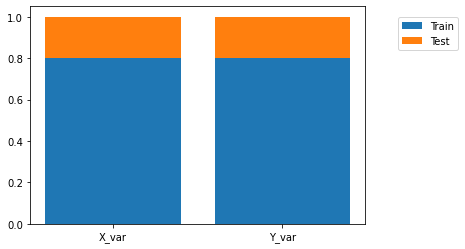

In [105]:
xplot = ['X_var','Y_var']
trainplot = [X_train.shape[0]/X.shape[0],y_train.shape[0]/y.shape[0]]
testplot = [X_test.shape[0]/X.shape[0],y_test.shape[0]/y.shape[0]]
fig, ax = plt.subplots()
ax.bar(xplot,trainplot,label = 'Train')
ax.bar(xplot,testplot,bottom = trainplot,label = 'Test')
ax.legend(loc = (1.1,0.8))

In [106]:
X_train.head()

,price,discount,available_quantity,listing_type_id,condition,domain_id,tags,state_name,city_name,power_seller_status,level_id,ranking_success,negative,positive,free_shipping,store_pick_up
2293,34999.0,0.000000,1,gold_special,new,MLA-TABLETS,good quality picture good quality thumbna...,Capital Federal,Balvanera,platinum,5_green,0.973946,0.00,1.00,0,0
3542,65694.0,0.000000,1,gold_pro,new,MLA-NOTEBOOKS,good quality picture good quality thumbna...,Santa Fe,Rosario,platinum,5_green,0.971469,0.03,0.96,0,0
862,108799.0,0.000000,1,gold_special,new,MLA-TELEVISIONS,extended warranty eligible good quality p...,Buenos Aires,La Plata,platinum,5_green,0.928036,0.03,0.92,0,0
2520,9395.0,0.000000,1,gold_special,new,MLA-TABLETS,extended warranty eligible good quality p...,Córdoba,Córdoba,platinum,5_green,0.946444,0.03,0.94,0,0
2632,9899.0,0.090909,1,gold_special,new,MLA-TABLETS,extended warranty eligible good quality p...,Córdoba,Córdoba,platinum,5_green,0.945735,0.01,0.96,0,0


In [107]:
X_train.shape

(2737, 16)

<a id="2.3"></a>
#### 2.4) Vectorizamos con Tf_idf

In [108]:
# stop_words=stop_words_m  no voy a sacar el ahora 12
vectorizer=TfidfVectorizer(lowercase=True,strip_accents='unicode',max_df=0.7)
vectorizer.fit(X_train['tags'])

TfidfVectorizer(max_df=0.7, strip_accents='unicode')

In [109]:
X_train_tags = pd.DataFrame(vectorizer.transform(X_train['tags']).todense() )
X_test_tags = pd.DataFrame(vectorizer.transform(X_test['tags']).todense() )

In [110]:
# tengo que dropear 'tags' y resetear los indices
X_train.drop(['tags'],axis =1, inplace = True)
X_test.drop(['tags'],axis =1, inplace = True)

X_train.reset_index(drop = True, inplace = True)
X_test.reset_index(drop = True, inplace = True)

In [111]:
# tambien lo aplico  a y
y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

<a id="2.4"></a>
#### 2.4 Encoding de variables categóricas
Vamos a tratar las variables categoricas usando la libreria de *OneHotEncoder*

In [112]:
# con OneHotEncoder creamos variables dummies para place_name
onehot_encoder = OneHotEncoder(sparse=False,handle_unknown='ignore')

#X train enconded
X_ohe_train = onehot_encoder.fit_transform(X_train[cat_features])
X_ohe_train = pd.DataFrame(X_ohe_train, columns = onehot_encoder.get_feature_names(cat_features))

#X test enconded
X_ohe_test = onehot_encoder.transform(X_test[cat_features])
X_ohe_test = pd.DataFrame(X_ohe_test, columns = onehot_encoder.get_feature_names(cat_features))

<a id="2.5"></a>
#### 2.5 Standarización de variables numéricas
Vamos a tratar las variables numericas, usando *MinMaxScaler* para hacer la normalizacion

In [113]:
# normalization of X_train
min_max_scaler = preprocessing.MinMaxScaler()
X_train_scaled = min_max_scaler.fit_transform(X_train[num_features])
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_features)


# normalization of X_test
X_test_scaled = min_max_scaler.transform(X_test[num_features])
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_features)

<a id="2.6"></a>
#### 2.6 Features de Train y Test

Finalmente vamos unificar lo trabajado hasta el momento para crear los set de train y test para el modelo

In [114]:
print('Sizes de los distintos datasets de entrenamiento y testeo')
print('Train Tags Vectorizado: ',X_train_tags.shape)
print('Train Tags Vectorizado: ', X_test_tags.shape)
print('--------------------------------------------------')
print('Train OHE: ' ,X_ohe_train.shape)
print('Test OHE: ', X_ohe_test.shape)
print('--------------------------------------------------')
print('Train Scaled: ',X_train_scaled.shape)
print('Test Scaled: ', X_test_scaled.shape)

Sizes de los distintos datasets de entrenamiento y testeo
Train Tags Vectorizado:  (2737, 28)
Train Tags Vectorizado:  (685, 28)
--------------------------------------------------
Train OHE:  (2737, 206)
Test OHE:  (685, 206)
--------------------------------------------------
Train Scaled:  (2737, 8)
Test Scaled:  (685, 8)


In [115]:
# concatenamos los datasets obtenidos hasta el momento
X_train = pd.concat([X_train_scaled, X_ohe_train , X_train_tags], axis = 1)
X_test = pd.concat([X_test_scaled, X_ohe_test, X_test_tags], axis = 1)

In [116]:
# luego de la unificacion
display(X_train.shape)
display(X_test.shape)

(2737, 242)

(685, 242)

In [117]:
display(y_train.shape)
display(y_test.shape)

(2737,)

(685,)

---
<a href="#top">Back to Index</a>
<a id="3"></a>
### 3) Modelos de Predicción


<a id="3.1"></a>
#### 3.1) Stats Model

<a id="3.1.1"></a>
##### 3.1.1) Regresión Lineal

Vamos a usar realizar una regresión lineal con Stats Model para poder analizar como se comportan las features del modelo.

In [118]:
# agregamos la columna para intercept
import statsmodels.api as sm  
X_train = sm.add_constant(X_train)

In [119]:
#fiteo el modelo
osl_m = sm.OLS(y_train,X_train,missing='drop').fit()

In [120]:
print(osl_m.summary())

                            OLS Regression Results                            
Dep. Variable:          sold_quantity   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     3.422
Date:                Thu, 19 Aug 2021   Prob (F-statistic):           2.79e-47
Time:                        10:46:10   Log-Likelihood:                -20013.
No. Observations:                2737   AIC:                         4.044e+04
Df Residuals:                    2528   BIC:                         4.168e+04
Df Model:                         208                                         
Covariance Type:            nonrobust                                         
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

In [122]:
#Creo lista con las columnas eliminadas
feature_removed=[]
def p_value(X_train,y_train,alpha):
    
    feature_over_alpha_limit=1
        
    while feature_over_alpha_limit>0:
       
        #creo DF que contenga los features que Quedan en el modelo
        df=pd.DataFrame(columns=['Feature','P_Value'])
        feature_names=X_train.columns

        #fiteo el modelo
        osl_m = sm.OLS(y_train,X_train).fit()

        #Genero DF con P Values
        for i in range (0, X_train.shape[1]):
            p_values=(osl_m.pvalues[i]).round(3)
            df.loc[i]=[feature_names[i],p_values]

        #obtengo el maximo P_value del modelo
        Max_feature=df['P_Value'].idxmax()
        Max_P_value=df['P_Value'].max()

        #obtengo el feature a eliminar del modelo
        feature_to_exclude=df.loc[[Max_feature],['Feature']].iat[0,0]
        feature_removed.append(feature_to_exclude)

        #Elimino el feature del modelo
        X_train.drop(feature_to_exclude,axis=1,inplace=True)

        #obtener lista con cantidad de features con P value > 0.05
        feature_over_alpha_limit=len([x for x in df['P_Value'] if float(x) >=alpha])

    print("La cantidad de Features removidos es: ",feature_removed,"\nEl R2 es: ",osl_m.rsquared_adj.round(3))

Aplicamos la función **p_value** para remover aquellos features en donde su p_value es mayor a 0.05

In [124]:
# tengo un error con la key 28 ## a resolver
#p_value(X_train,y_train,0.05)

In [125]:
#feature_removed

<a id="3.1.2"></a>
##### 3.1.2) Regresión Lineal con Feature Selection

In [126]:
#fiteo el modelo
osl_m = sm.OLS(y_train,X_train).fit()
print(osl_m.summary())

                            OLS Regression Results                            
Dep. Variable:          sold_quantity   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     3.422
Date:                Thu, 19 Aug 2021   Prob (F-statistic):           2.79e-47
Time:                        10:47:02   Log-Likelihood:                -20013.
No. Observations:                2737   AIC:                         4.044e+04
Df Residuals:                    2528   BIC:                         4.168e+04
Df Model:                         208                                         
Covariance Type:            nonrobust                                         
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

In [127]:
#Eliminamos los features que eliminamos en el training
X_test.drop(feature_removed,axis=1,inplace=True)

In [128]:
#agregamos la constante del modelo OLS
X_test = sm.add_constant(X_test)

In [129]:
#Fiteamos el modelo 
y_pred=osl_m.predict(X_test)

In [130]:
# Evaluamos el R2 usando Sklearn
r2_score(y_test, y_pred)

0.3135350833805619

<a id="3.1.3"></a>
##### 3.1.3) VIF (Variance Inflation Factor)

In [131]:
# Import library for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif.sort_values(by='VIF',ascending=False)
    return(vif)

In [132]:
calc_vif(X_train)

,variables,VIF
0,price,3.016652
1,discount,1.494609
2,available_quantity,3.003503
3,ranking_success,3.204932
4,negative,3.437606
...,...,...
237,23,inf
238,24,inf
239,25,inf
240,26,inf


<a id="3.1.4"></a>
##### 3.1.4) RFE (Feature Ranking with recursive elimination)

Documentación: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html

In [ ]:
#X_train.drop('const',axis=1,inplace=True)
#X_test.drop('const',axis=1,inplace=True)

In [133]:
# instanciamos y entrenamos el modelo
kf = KFold(n_splits=5, shuffle = True)
estimator = RandomForestRegressor()
selector = RFECV(estimator, step = 1, cv=kf, scoring = 'r2', verbose=2)
selector.fit(X_train, y_train)

Fitting estimator with 242 features.
Fitting estimator with 241 features.
Fitting estimator with 240 features.
Fitting estimator with 239 features.
Fitting estimator with 238 features.
Fitting estimator with 237 features.
Fitting estimator with 236 features.
Fitting estimator with 235 features.
Fitting estimator with 234 features.
Fitting estimator with 233 features.
Fitting estimator with 232 features.
Fitting estimator with 231 features.
Fitting estimator with 230 features.
Fitting estimator with 229 features.
Fitting estimator with 228 features.
Fitting estimator with 227 features.
Fitting estimator with 226 features.
Fitting estimator with 225 features.
Fitting estimator with 224 features.
Fitting estimator with 223 features.
Fitting estimator with 222 features.
Fitting estimator with 221 features.
Fitting estimator with 220 features.
Fitting estimator with 219 features.
Fitting estimator with 218 features.
Fitting estimator with 217 features.
Fitting estimator with 216 features.
F

Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 242 features.
Fitting estimator with 241 features.
Fitting estimator with 240 features.
Fitting estimator with 239 features.
Fitting estimator with 238 features.
Fitting estimator with 237 features.
Fitting estimator with 236 features.
Fitting estimator with 235 features.
Fitting estimator with 234 features.
Fitting estimator with 233 features.
Fitting estimator with 232

Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 feat

Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 fe

Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 fe

Fitting estimator with 86 features.
Fitting estimator with 85 features.
Fitting estimator with 84 features.
Fitting estimator with 83 features.
Fitting estimator with 82 features.
Fitting estimator with 81 features.
Fitting estimator with 80 features.
Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.
Fitting estimator with 72 features.
Fitting estimator with 71 features.
Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 fe

Fitting estimator with 103 features.
Fitting estimator with 102 features.
Fitting estimator with 101 features.
Fitting estimator with 100 features.
Fitting estimator with 99 features.


RFECV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
      estimator=RandomForestRegressor(), scoring='r2', verbose=2)

In [134]:
selector

RFECV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
      estimator=RandomForestRegressor(), scoring='r2', verbose=2)

In [135]:
X_train.loc[:,selector.support_].columns

Index([                                            'price',
                                                'discount',
                                      'available_quantity',
                                         'ranking_success',
                                                'negative',
                                                'positive',
                                'listing_type_id_gold_pro',
                            'listing_type_id_gold_special',
       'domain_id_MLA-AUDIO_AND_VIDEO_CABLES_AND_ADAPTERS',
                                'domain_id_MLA-CELLPHONES',
                                 'domain_id_MLA-NOTEBOOKS',
                   'domain_id_MLA-STREAMING_MEDIA_DEVICES',
                                   'domain_id_MLA-TABLETS',
                               'domain_id_MLA-TELEVISIONS',
                        'domain_id_MLA-TV_REMOTE_CONTROLS',
                                 'state_name_Buenos Aires',
                              'state_nam

In [136]:
scores = pd.DataFrame()
scores['Attribute Name'] = X_train.columns
scores['Ranking'] = selector.ranking_
scores['Support'] = selector.support_

display(scores.sort_values(by='Ranking',ascending=True))

,Attribute Name,Ranking,Support
0,price,1,True
177,city_name_Sarandi,1,True
170,city_name_San Nicolás,1,True
163,city_name_San Isidro,1,True
161,city_name_San Cristóbal,1,True
...,...,...,...
185,city_name_Villa Bosch,141,False
175,city_name_Santo Tomé,142,False
165,city_name_San José De Guaymallen,143,False
26,state_name_La Pampa,144,False


In [137]:
scores[scores['Ranking']==1].sort_values(by='Ranking',ascending=True)

,Attribute Name,Ranking,Support
0,price,1,True
210,power_seller_status_gold,1,True
206,city_name_Yerba Buena,1,True
203,city_name_Villa del Parque,1,True
202,city_name_Villa Urquiza,1,True
...,...,...,...
58,city_name_Béccar,1,True
57,city_name_Buenos Aires,1,True
55,city_name_Boedo,1,True
50,city_name_Barracas,1,True


<a id="3.2"></a>
#### 3.2) CatBoost

CatBoost Tuneado

In [138]:
# Función para evaluar el rendimiento del modelo con los datos de Train
def evaluar_rendimiento(modelo, nombre, X, y, cv, scoring='r2'):
    s = cross_val_score(modelo, X, y, cv=cv, n_jobs=-1, scoring=scoring)
    print("Rendimiento de {}:\t{:0.3} ± {:0.3}".format( \
        nombre, s.mean().round(3), s.std().round(3)))
    return s.mean()

In [139]:
# DataFrame para guardar el desempeño de los modelos
model_comparison = pd.DataFrame(columns = {'Model'})
# model_comparison

In [140]:
# Instanciamos Cross Validation
cv = KFold(n_splits=5, random_state=42, shuffle=True)

In [141]:
# Instanciamos el modelo que vamos a entrenar
model_cbr = CatBoostRegressor()
model_comparison.loc[1,'Model'] = 'CatBoostRegressor'

In [142]:
# Creamos la grilla de parametros
params = {  
      
    "depth": [5,6,7,8,9],            
    "learning_rate": [0.001, 0.01, 0.1],
    "l2_leaf_reg":[1.0,0.1]
}

In [143]:
# Creamos la grilla con GridSearch
cbr = GridSearchCV(model_cbr, param_grid=params, cv=cv, verbose=1, n_jobs=-1)

In [144]:
# Entrenamos el modelo
cbr.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  7.5min finished


0:	learn: 410.1324241	total: 144ms	remaining: 2m 23s
1:	learn: 409.9364829	total: 154ms	remaining: 1m 17s
2:	learn: 409.7371553	total: 165ms	remaining: 54.9s
3:	learn: 409.5341622	total: 176ms	remaining: 43.8s
4:	learn: 409.3403300	total: 187ms	remaining: 37.2s
5:	learn: 409.1447210	total: 198ms	remaining: 32.8s
6:	learn: 408.9493011	total: 208ms	remaining: 29.5s
7:	learn: 408.7570578	total: 218ms	remaining: 27.1s
8:	learn: 408.5627142	total: 230ms	remaining: 25.3s
9:	learn: 408.3714313	total: 240ms	remaining: 23.8s
10:	learn: 408.2256312	total: 251ms	remaining: 22.6s
11:	learn: 408.0308519	total: 262ms	remaining: 21.6s
12:	learn: 407.8319697	total: 266ms	remaining: 20.2s
13:	learn: 407.6381507	total: 277ms	remaining: 19.5s
14:	learn: 407.4915603	total: 287ms	remaining: 18.9s
15:	learn: 407.2895640	total: 298ms	remaining: 18.3s
16:	learn: 407.0934508	total: 308ms	remaining: 17.8s
17:	learn: 406.9507848	total: 319ms	remaining: 17.4s
18:	learn: 406.7565135	total: 334ms	remaining: 17.2s
1

161:	learn: 381.8679506	total: 1.91s	remaining: 9.89s
162:	learn: 381.6893445	total: 1.92s	remaining: 9.88s
163:	learn: 381.5568175	total: 1.94s	remaining: 9.87s
164:	learn: 381.4236718	total: 1.95s	remaining: 9.86s
165:	learn: 381.2393434	total: 1.96s	remaining: 9.85s
166:	learn: 381.0564509	total: 1.97s	remaining: 9.83s
167:	learn: 380.8789661	total: 1.98s	remaining: 9.81s
168:	learn: 380.6943112	total: 1.99s	remaining: 9.79s
169:	learn: 380.5174039	total: 2s	remaining: 9.78s
170:	learn: 380.3435930	total: 2.01s	remaining: 9.77s
171:	learn: 380.1654164	total: 2.02s	remaining: 9.75s
172:	learn: 379.9885500	total: 2.04s	remaining: 9.73s
173:	learn: 379.8148711	total: 2.05s	remaining: 9.72s
174:	learn: 379.6842378	total: 2.06s	remaining: 9.7s
175:	learn: 379.5083540	total: 2.07s	remaining: 9.68s
176:	learn: 379.3338258	total: 2.08s	remaining: 9.67s
177:	learn: 379.2026422	total: 2.09s	remaining: 9.65s
178:	learn: 379.0254695	total: 2.1s	remaining: 9.63s
179:	learn: 378.8934510	total: 2.

317:	learn: 357.1041294	total: 3.63s	remaining: 7.79s
318:	learn: 356.9774631	total: 3.64s	remaining: 7.78s
319:	learn: 356.8163235	total: 3.65s	remaining: 7.76s
320:	learn: 356.6544296	total: 3.66s	remaining: 7.75s
321:	learn: 356.4871017	total: 3.67s	remaining: 7.74s
322:	learn: 356.3306921	total: 3.69s	remaining: 7.72s
323:	learn: 356.2097381	total: 3.69s	remaining: 7.71s
324:	learn: 356.0408215	total: 3.71s	remaining: 7.7s
325:	learn: 355.8797839	total: 3.71s	remaining: 7.68s
326:	learn: 355.7530042	total: 3.73s	remaining: 7.67s
327:	learn: 355.5860941	total: 3.74s	remaining: 7.65s
328:	learn: 355.4667571	total: 3.75s	remaining: 7.64s
329:	learn: 355.2989051	total: 3.75s	remaining: 7.63s
330:	learn: 355.1366480	total: 3.77s	remaining: 7.61s
331:	learn: 354.9701447	total: 3.77s	remaining: 7.6s
332:	learn: 354.8144828	total: 3.79s	remaining: 7.58s
333:	learn: 354.6965532	total: 3.79s	remaining: 7.57s
334:	learn: 354.5770459	total: 3.81s	remaining: 7.55s
335:	learn: 354.4596589	total:

487:	learn: 332.9264200	total: 5.35s	remaining: 5.61s
488:	learn: 332.7737044	total: 5.36s	remaining: 5.6s
489:	learn: 332.6571488	total: 5.37s	remaining: 5.59s
490:	learn: 332.5136936	total: 5.38s	remaining: 5.58s
491:	learn: 332.4065406	total: 5.39s	remaining: 5.57s
492:	learn: 332.2908625	total: 5.4s	remaining: 5.56s
493:	learn: 332.1824771	total: 5.41s	remaining: 5.54s
494:	learn: 332.0387774	total: 5.42s	remaining: 5.53s
495:	learn: 331.9307166	total: 5.43s	remaining: 5.52s
496:	learn: 331.7905530	total: 5.45s	remaining: 5.51s
497:	learn: 331.6448046	total: 5.46s	remaining: 5.5s
498:	learn: 331.4987963	total: 5.46s	remaining: 5.49s
499:	learn: 331.3483751	total: 5.47s	remaining: 5.47s
500:	learn: 331.2038848	total: 5.49s	remaining: 5.46s
501:	learn: 331.0603130	total: 5.5s	remaining: 5.45s
502:	learn: 330.9151681	total: 5.5s	remaining: 5.44s
503:	learn: 330.7719168	total: 5.51s	remaining: 5.43s
504:	learn: 330.6623874	total: 5.53s	remaining: 5.42s
505:	learn: 330.5115412	total: 5.

656:	learn: 311.2072245	total: 7.06s	remaining: 3.69s
657:	learn: 311.0702058	total: 7.07s	remaining: 3.67s
658:	learn: 310.9337526	total: 7.08s	remaining: 3.66s
659:	learn: 310.8299626	total: 7.09s	remaining: 3.65s
660:	learn: 310.7263631	total: 7.1s	remaining: 3.64s
661:	learn: 310.5903641	total: 7.11s	remaining: 3.63s
662:	learn: 310.4893380	total: 7.12s	remaining: 3.62s
663:	learn: 310.3708974	total: 7.13s	remaining: 3.61s
664:	learn: 310.2298384	total: 7.14s	remaining: 3.6s
665:	learn: 310.1003136	total: 7.15s	remaining: 3.59s
666:	learn: 309.9994959	total: 7.16s	remaining: 3.58s
667:	learn: 309.8908171	total: 7.17s	remaining: 3.56s
668:	learn: 309.7606774	total: 7.18s	remaining: 3.55s
669:	learn: 309.6609565	total: 7.19s	remaining: 3.54s
670:	learn: 309.5254692	total: 7.2s	remaining: 3.53s
671:	learn: 309.4114458	total: 7.21s	remaining: 3.52s
672:	learn: 309.2807630	total: 7.22s	remaining: 3.51s
673:	learn: 309.1522273	total: 7.23s	remaining: 3.5s
674:	learn: 309.0216678	total: 7

826:	learn: 291.7971803	total: 8.8s	remaining: 1.84s
827:	learn: 291.7075352	total: 8.81s	remaining: 1.83s
828:	learn: 291.6169400	total: 8.83s	remaining: 1.82s
829:	learn: 291.4902900	total: 8.84s	remaining: 1.81s
830:	learn: 291.3778870	total: 8.85s	remaining: 1.8s
831:	learn: 291.2503466	total: 8.86s	remaining: 1.79s
832:	learn: 291.1602124	total: 8.87s	remaining: 1.78s
833:	learn: 291.0443826	total: 8.87s	remaining: 1.77s
834:	learn: 290.9508351	total: 8.88s	remaining: 1.75s
835:	learn: 290.8323030	total: 8.89s	remaining: 1.74s
836:	learn: 290.7384867	total: 8.9s	remaining: 1.73s
837:	learn: 290.6204507	total: 8.91s	remaining: 1.72s
838:	learn: 290.5329404	total: 8.92s	remaining: 1.71s
839:	learn: 290.4447287	total: 8.93s	remaining: 1.7s
840:	learn: 290.3210315	total: 8.94s	remaining: 1.69s
841:	learn: 290.2334563	total: 8.95s	remaining: 1.68s
842:	learn: 290.1071016	total: 8.96s	remaining: 1.67s
843:	learn: 289.9905301	total: 8.97s	remaining: 1.66s
844:	learn: 289.8922530	total: 8

991:	learn: 275.3643517	total: 10.5s	remaining: 84.5ms
992:	learn: 275.2829351	total: 10.5s	remaining: 74ms
993:	learn: 275.2005414	total: 10.5s	remaining: 63.4ms
994:	learn: 275.1184362	total: 10.5s	remaining: 52.8ms
995:	learn: 275.0057629	total: 10.5s	remaining: 42.3ms
996:	learn: 274.9085685	total: 10.5s	remaining: 31.7ms
997:	learn: 274.7995187	total: 10.5s	remaining: 21.1ms
998:	learn: 274.6867706	total: 10.6s	remaining: 10.6ms
999:	learn: 274.5759389	total: 10.6s	remaining: 0us


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=<catboost.core.CatBoostRegressor object at 0x000001E90B5BAD90>,
             n_jobs=-1,
             param_grid={'depth': [5, 6, 7, 8, 9],
                         'learning_rate': [0.001, 0.01, 0.1]},
             verbose=1)

In [145]:
# Mejores parametros 
print('Best parameters:  ',cbr.best_params_)

# Evaluamos el rendimiento del modelo
model_comparison.loc[1,'Train_score'] = evaluar_rendimiento(cbr.best_estimator_,"CatBoost", X_train, y_train, cv)

# Calculamos las predicciones
y_pred_cbr = cbr.predict(X_test)

#Rendimiento del modelo con los datos de test
r2 = r2_score(y_test,y_pred_cbr)
print('r² es igual a: ', r2)
model_comparison.loc[1,'Test_score'] = r2

# Ploteamos las features importantes
#from xgboost import plot_importance
#plot_importance(xgb.best_estimator_, height = 0.8,max_num_features=15)

Best parameters:   {'depth': 9, 'learning_rate': 0.001}
Rendimiento de CatBoost:	0.235 ± 0.302
r² es igual a:  0.32044943488806266


<AxesSubplot:>

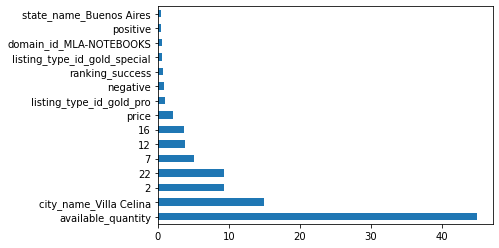

In [146]:
feat_importances = pd.Series(cbr.best_estimator_.get_feature_importance(), index=X_test.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [147]:
model_comparison

,Model,Train_score,Test_score
1,CatBoostRegressor,0.234517,0.320449


<a href="#top">Back to Index</a>
<a id="4"></a>
### 4) Conclusion de Parte II

En esta instancia se trato de realizar un modelo para poder predecir las unidades vendidas *sold_quantity* de una publicacion.
Si bien los valores obtenidos son bajos, hay que tomar en cuenta la informacion del data set.
Existen muchos datos referidos al vendedor, y los elementos de tag son muy genericos no necesariamente de la publicacion, posiblemente con datos especificos de las publicaciones utilizando otro recurso de la API de MELI se pueden obtener datos referentes al producto del campo ***atributes: {}*** mediante la ***id*** de cada publicacion.

Tambien mas que hacerlo generico, crearia un modelo para cada uno de las distintas categorias del modelo,
ya sea televisores, celulares, etc. y repetir el entrenamiento, muy posiblemente algunas variables sean comunes.

Queda pendiente, al momento de usar Vectorizamos con ***TfidfVectorizer***, identificar el nombre de las variables de la matriz exparsa con las palabras de ***tags*** para poder ver con el feature importance 



##### Edit: EXTRA
##### Como extra tratare de traer atributos extra de la publicacion referidos al producto en si, por ello aun conserve id en este punto.

In [148]:
## extra get data
import requests
from time import time, sleep
import re

# hago otra consulta
url = 'https://api.mercadolibre.com/items/MLA898264823'
result = requests.get(url)
consulta = result.json()

In [149]:
consulta['attributes']

[{'id': 'BRAND',
  'name': 'Marca',
  'value_id': '16457',
  'value_name': 'TCL',
  'value_struct': None,
  'values': [{'id': '16457', 'name': 'TCL', 'struct': None}],
  'attribute_group_id': 'MAIN',
  'attribute_group_name': 'Principales'},
 {'id': 'MODEL',
  'name': 'Modelo',
  'value_id': '7803013',
  'value_name': '50P8M',
  'value_struct': None,
  'values': [{'id': '7803013', 'name': '50P8M', 'struct': None}],
  'attribute_group_id': 'MAIN',
  'attribute_group_name': 'Principales'},
 {'id': 'ACCESSORIES_INCLUDED',
  'name': 'Accesorios incluidos',
  'value_id': None,
  'value_name': 'Control remoto,Baterías,Cable de alimentación',
  'value_struct': None,
  'values': [{'id': '2296420', 'name': 'Control remoto', 'struct': None},
   {'id': None, 'name': 'Baterías', 'struct': None},
   {'id': '7609642', 'name': 'Cable de alimentación', 'struct': None}],
  'attribute_group_id': 'OTHERS',
  'attribute_group_name': 'Otros'},
 {'id': 'ASPECT_RATIO',
  'name': 'Relación de aspecto',
  'val

In [150]:
auxic = pd.DataFrame(consulta['attributes']).T
auxic.columns = auxic.iloc[0]
auxic = auxic[auxic.index == 'value_name']#.reset_index(drop = True)
auxic.index = ['prueba']
auxic

id,BRAND,MODEL,ACCESSORIES_INCLUDED,ASPECT_RATIO,BRIGHTNESS,COLOR,CONTRAST_RATIO,DEPTH,DISPLAY_SIZE,DISPLAY_TYPE,...,WEIGHT,WIDTH,WITH_BLUETOOTH,WITH_ETHERNET,WITH_HDMI,WITH_HDR,WITH_INTEGRATED_VOICE_COMMAND,WITH_SCREEN_SHARE_FUNCTION,WITH_USB,WITH_WI_FI
prueba,TCL,50P8M,"Control remoto,Baterías,Cable de alimentación",16:9,270 cd/m²,Negro,5000:1,8.1 cm,"50 """,LED,...,9.8 kg,112.1 cm,Sí,Sí,Sí,Sí,Sí,Sí,Sí,Sí


In [153]:
# voy a definir una función para realizar las consultas, y tomar el resultado y entregarlo como un dataset
def call_data2(serie_id, serie_index):
    '''Funcion para llamar a la API de mercado libre con un resultado especifico para cada idem extrayendo los datos en un dataframe
    y guardandolas en un data frame'''
    t = len(serie_id)
    df_rta = pd.DataFrame() #instancio un dataframe vacio, si bien no es una buena practica para este caso es una alternativa
    for t in list(range( 0,len(serie_id),1 ) ):
        url_act = 'https://api.mercadolibre.com/items/' + str( serie_id[t] )
        #print(url_act) #solo para corroborar
        result = requests.get(url_act)
        if result.status_code == 200:
            try:
                auxic = pd.DataFrame( result.json()['attributes'] ).T
                auxic.columns = auxic.iloc[0]
                auxic = auxic[auxic.index == 'value_name']#.reset_index(drop = True)
                auxic.index = [serie_index[t]]
                df_rta = pd.concat([df_rta, auxic], axis = 0)
            except KeyError:
                continue
        else:
            print('hubo un error')
            return df_rta
        print(t, end="\r")
        sleep(10) #cada 15 segundos ##cambio a 10 seg
          
    return df_rta

In [154]:
call_data2(list(data_m.id[data_m.index[[3,3245]]]), list(data_m.index[[3,3245]]))

,AUDIO_AND_VIDEO_INTERFACES,AUDIO_QUALITY,BRAND,COLOR,COMPATIBLE_APPLICATIONS,COMPATIBLE_DEVICES,CPU,DEVICE_FORMAT,EXCLUSIVE_CHANNEL,FREQUENCIES,...,WITH_ETHERNET_PORT,WITH_FINGERPRINT_READER,WITH_HDMI,WITH_HEADPHONES_OUTPUT,WITH_MEMORY_CARD_READER,WITH_MICROPHONE,WITH_NUMERIC_PAD,WITH_TOUCH_SCREEN,WITH_USB,WITH_WEBCAM
3,HDMI,"Dolby Digital Plus,Wave,Vorbis,Dolby Atmos",Amazon,Negro,"Netflix,YouTube,Amazon Prime Video,Starz,Showt...",Televisores,ARM Cortex-A53 Quad-Core,Stick,Mercado Libre,"2.4GHz,5GHz",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3953,NaN,NaN,Lenovo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Sí,Sí,Sí,Sí,Sí,Sí,Sí,No,Sí,Sí


<p><strong> Para esta instancia tendria que realizar una consulta cada 15 segundos para no saturar la API.
    un total de 3422 consultas implicaria 51.330 segundos, poco mas de 14,25 hs (14hs y 15min). Por lo tanto solamente me concentrare en las consultas relacionadas con celulares, es decir, <i>domain_id == MLA/CELLPHONES</i>.</strong></p>

In [155]:
data_cell = data_m[data_m.domain_id == 'MLA-CELLPHONES'].copy()
data_cell

,price,discount,available_quantity,sold_quantity,listing_type_id,condition,domain_id,tags,state_name,city_name,power_seller_status,level_id,ranking_success,negative,positive,free_shipping,store_pick_up,id
1040,42999.0,0.140003,540,652,gold_pro,new,MLA-CELLPHONES,good quality picture good quality thumbna...,Capital Federal,Capital Federal,platinum,5_green,0.945330,0.03,0.95,0,0,MLA926939463
1041,88444.0,0.000000,30,1,gold_pro,new,MLA-CELLPHONES,x campaign extended warranty eligible ...,Capital Federal,Villa Crespo,platinum,5_green,0.938183,0.04,0.93,0,0,MLA927083958
1042,14190.0,0.111403,31,7,gold_pro,new,MLA-CELLPHONES,x campaign catalog boost extended warr...,Capital Federal,Monte Castro,platinum,5_green,0.946411,0.03,0.95,0,0,MLA923645698
1043,21779.0,0.000000,3,8,gold_pro,new,MLA-CELLPHONES,x campaign extended warranty eligible ...,Capital Federal,C.A.B.A,platinum,5_green,0.945361,0.05,0.93,0,0,MLA933444651
1044,15499.0,0.000000,782,10459,gold_pro,new,MLA-CELLPHONES,good quality picture loyalty discount eli...,Buenos Aires,Villa Celina,platinum,5_green,0.953807,0.06,0.93,0,0,MLA884250759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2063,24409.0,0.000000,1,2,gold_special,new,MLA-CELLPHONES,brand verified extended warranty eligible...,Chubut,Trelew,platinum,5_green,0.931818,0.03,0.94,0,0,MLA905550334
2065,34159.0,0.000000,1,5,gold_pro,new,MLA-CELLPHONES,loyalty discount eligible brand verified ...,Santa Fe,Elortondo,platinum,5_green,0.926848,0.03,0.95,0,0,MLA863057362
2066,85900.0,0.000000,50,3,gold_special,new,MLA-CELLPHONES,brand verified extended warranty eligible...,Capital Federal,Colegiales,platinum,5_green,0.918302,0.02,0.97,0,0,MLA840387600
2068,14879.0,0.000000,50,5,gold_pro,new,MLA-CELLPHONES,good quality picture good quality thumbna...,Capital Federal,Monte Castro,platinum,5_green,0.946411,0.03,0.95,0,0,MLA912337995


In [158]:
data_cell_att =call_data2(list(data_cell.id[data_cell.index[range(0,780,1)]]), list(data_cell.index[range(0,780,1)]))

#data_cell_attributes=call_data2(list(data_cell.id[data_cell.index[range(0,100,1)]]), list(data_cell.index[range(0,100,1)]))
#sleep(10)
#data_cell_attributes2=call_data2(list(data_cell.id[data_cell.index[range(100,200,1)]]), list(data_cell.index[range(100,200,1)]))
#sleep(10)
#data_cell_attributes3=call_data2(list(data_cell.id[data_cell.index[range(200,300,1)]]), list(data_cell.index[range(200,300,1)]))
#sleep(10)
#data_cell_attributes4=call_data2(list(data_cell.id[data_cell.index[range(300,400,1)]]), list(data_cell.index[range(300,400,1)]))
#sleep(10)
#data_cell_attributes5=call_data2(list(data_cell.id[data_cell.index[range(400,500,1)]]), list(data_cell.index[range(400,500,1)]))
#sleep(10)
#data_cell_attributes6=call_data2(list(data_cell.id[data_cell.index[range(500,600,1)]]), list(data_cell.index[range(500,600,1)]))
#sleep(10)
#data_cell_attributes7=call_data2(list(data_cell.id[data_cell.index[range(600,700,1)]]), list(data_cell.index[range(600,700,1)]))
#sleep(10)
#data_cell_attributes8=call_data2(list(data_cell.id[data_cell.index[range(700,780,1)]]), list(data_cell.index[range(700,780,1)]))

In [159]:
#data_cell_att = pd.concat([data_cell_attributes,\
#           data_cell_attributes2,
#           data_cell_attributes3,
#           data_cell_attributes4,
#           data_cell_attributes5,
#           data_cell_attributes6,
#           data_cell_attributes7,
#           data_cell_attributes8], axis = 0)
data_cell_att

,BATTERY_CAPACITY,BATTERY_TYPE,BRAND,CAMERAS_MAIN_FEATURES,CARRIER,CHARGE_CONNECTOR_TYPE,COLOR,CPU_MODELS,DEPTH,DISPLAY_ASPECT_RATIO,...,DIMENSIONS,WITH_LANTERN,WITH_SLOW_MOTION_CAMERA_FUNCTION,SCREEN_TECHNOLOGY,MANUFACTURING_TIME,WITH_FOLDABLE_SCREEN,IS_FLAMMABLE,REFURBISHED_CELLPHONES,MP3,USB_CONNECTION
1040,5000 mAh,Polímero de litio,Xiaomi,"Nigth mode,Timed burst,Portrait mode,AI beauti...",Liberado,USB-C,Azul nocturno,"2x2.2 GHz Cortex-A76,6x2 GHz Cortex-A55",8.92 mm,20 - 9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1041,5000 mAh,NaN,Motorola,"Night vision,HDR,Panorama,Burst shot",Liberado,USB-C,Verde boreal,NaN,9.7 mm,21 - 9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1042,3000 mAh,NaN,TCL,"LED Flash,Autofocus",Liberado,Micro USB,Negro,4x1.3 GHz Cortex-A53,9.9 mm,18 - 9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1043,4000 mAh,NaN,Motorola,"Portrait mode,Panorama,Beautify,HDR,Night visi...",Liberado,USB-C,Azul aqua,"4x2 GHz Cortex-A53,4x1.5 GHz Cortex-A53",8.89 mm,20 - 9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1044,3000 mAh,Ion de litio,Samsung,NaN,Liberado,Micro USB,Negro,4x1.5 GHz Cortex-A53,8.6 mm,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2063,NaN,NaN,LG,NaN,Liberado,Micro USB,NaN,NaN,8.3 mm,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2065,4000 mAh,Ion de litio,LG,"Food,Flash Jump-Cut,Macro focus,Focus lock (AE...",Liberado,USB-C,NaN,"4x2 GHz Cortex-A53,4x1.5 GHz Cortex-A53",8.2 mm,19.5 - 9,...,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2066,5500 mAh,NaN,Ulefone,NaN,Liberado,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2068,2700 mAh,Ion de litio,Kodak,NaN,Liberado,Micro USB,NaN,NaN,9.9 mm,18 - 9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [160]:
# debido a la alerta de memory usage lo fracciono en dos partes
data_cell_att.iloc[:, list(range(0,100,1))].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 772 entries, 1040 to 2069
Data columns (total 100 columns):
 #   Column                                           Non-Null Count  Dtype 
---  ------                                           --------------  ----- 
 0   BATTERY_CAPACITY                                 740 non-null    object
 1   BATTERY_TYPE                                     550 non-null    object
 2   BRAND                                            772 non-null    object
 3   CAMERAS_MAIN_FEATURES                            260 non-null    object
 4   CARRIER                                          772 non-null    object
 5   CHARGE_CONNECTOR_TYPE                            555 non-null    object
 6   COLOR                                            132 non-null    object
 7   CPU_MODELS                                       466 non-null    object
 8   DEPTH                                            707 non-null    object
 9   DISPLAY_ASPECT_RATIO                  

In [161]:
# debido a la alerta de memory usage lo fracciono en dos partes
data_cell_att.iloc[:, list(range(100,149,1))].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 772 entries, 1040 to 2069
Data columns (total 49 columns):
 #   Column                                                  Non-Null Count  Dtype 
---  ------                                                  --------------  ----- 
 0   ADDITIONAL_INFO_REQUIRED                                71 non-null     object
 1   BATTERIES_FEATURES                                      65 non-null     object
 2   IS_WATERPROOF                                           311 non-null    object
 3   PRODUCT_FEATURES                                        93 non-null     object
 4   SHIPMENT_PACKING                                        100 non-null    object
 5   OPERATING_SYSTEM_LAST_COMPATIBLE_VERSION                42 non-null     object
 6   OPERATING_SYSTEM_PERSONALIZATION_LAST_COMPATIBLE_SHELL  28 non-null     object
 7   OPTICAL_ZOOM                                            42 non-null     object
 8   CLOSED_DEPTH                                  

Existe una gran cantidad de elementos no nulos en el dataframe *data_cell_att*, por lo tanto voy a filtrar aquellos que tengan una gran cantidad de valores nulos (al menos 100).

In [162]:
columns_att = list(data_cell_att.columns)
columns_att_less_nulls = []
for atributo in columns_att:
    if data_cell_att[atributo].isnull().sum() < 100:
        columns_att_less_nulls.extend( [atributo] )
        #print(atributo) #para comprobar
        
len(columns_att_less_nulls)

31

In [163]:
columns_att_less_nulls

['BATTERY_CAPACITY',
 'BRAND',
 'CARRIER',
 'DEPTH',
 'DISPLAY_RESOLUTION',
 'DISPLAY_SIZE',
 'HEIGHT',
 'INTERNAL_MEMORY',
 'IS_DUAL_SIM',
 'ITEM_CONDITION',
 'LINE',
 'MAIN_FRONT_CAMERA_RESOLUTION',
 'MAIN_REAR_CAMERA_RESOLUTION',
 'MOBILE_NETWORK',
 'MODEL',
 'NUMBER_OF_SIM_CARD_SLOTS',
 'OPERATING_SYSTEM_NAME',
 'PROCESSOR_CORES_NUMBER',
 'RAM',
 'REAR_CAMERAS_NUMBER',
 'SIM_SIZES',
 'WEIGHT',
 'WIDTH',
 'WITH_BLUETOOTH',
 'WITH_CAMERA',
 'WITH_GPS',
 'WITH_IMEI',
 'WITH_PHYSICAL_QWERTY_KEYBOARD',
 'WITH_TOUCHSCREEN_DISPLAY',
 'WITH_USB_CONNECTOR',
 'WITH_WIFI']

In [164]:
data_cell_att[columns_att_less_nulls].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 772 entries, 1040 to 2069
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   BATTERY_CAPACITY               740 non-null    object
 1   BRAND                          772 non-null    object
 2   CARRIER                        772 non-null    object
 3   DEPTH                          707 non-null    object
 4   DISPLAY_RESOLUTION             706 non-null    object
 5   DISPLAY_SIZE                   736 non-null    object
 6   HEIGHT                         707 non-null    object
 7   INTERNAL_MEMORY                772 non-null    object
 8   IS_DUAL_SIM                    772 non-null    object
 9   ITEM_CONDITION                 772 non-null    object
 10  LINE                           680 non-null    object
 11  MAIN_FRONT_CAMERA_RESOLUTION   685 non-null    object
 12  MAIN_REAR_CAMERA_RESOLUTION    706 non-null    object
 13  M

In [165]:
data_cell_att_minus = data_cell_att[columns_att_less_nulls].copy()

In [166]:
data_cell_att_minus.shape

(772, 31)

In [167]:
# completo los valores de los campos en lugar de Sí o No con NE "No Especifica"
columnas_sino = ['IS_DUAL_SIM','WITH_BLUETOOTH','WITH_CAMERA','WITH_GPS','WITH_IMEI','WITH_PHYSICAL_QWERTY_KEYBOARD',\
                 'WITH_TOUCHSCREEN_DISPLAY','WITH_USB_CONNECTOR','WITH_WIFI',\
# considero estas opciones 
                'OPERATING_SYSTEM_NAME','MAIN_FRONT_CAMERA_RESOLUTION','MAIN_REAR_CAMERA_RESOLUTION']
data_cell_att_minus[columnas_sino] = data_cell_att_minus[columnas_sino].fillna('NE') ### completo con NE
data_cell_att_minus[columnas_sino]

,IS_DUAL_SIM,WITH_BLUETOOTH,WITH_CAMERA,WITH_GPS,WITH_IMEI,WITH_PHYSICAL_QWERTY_KEYBOARD,WITH_TOUCHSCREEN_DISPLAY,WITH_USB_CONNECTOR,WITH_WIFI,OPERATING_SYSTEM_NAME,MAIN_FRONT_CAMERA_RESOLUTION,MAIN_REAR_CAMERA_RESOLUTION
1040,Sí,Sí,Sí,Sí,Sí,No,Sí,Sí,Sí,Android,8 Mpx,48 Mpx
1041,No,Sí,Sí,Sí,Sí,No,Sí,Sí,Sí,Android,16 Mpx,64 Mpx
1042,No,Sí,Sí,Sí,Sí,No,Sí,Sí,Sí,Android,5 Mpx,8 Mpx
1043,No,Sí,Sí,Sí,Sí,No,Sí,Sí,Sí,Android,5 Mpx,48 Mpx
1044,No,Sí,Sí,Sí,Sí,No,Sí,Sí,Sí,Android,5 Mpx,8 Mpx
...,...,...,...,...,...,...,...,...,...,...,...,...
2063,No,Sí,Sí,Sí,Sí,No,Sí,Sí,Sí,Android,NE,NE
2065,No,Sí,Sí,Sí,Sí,No,Sí,Sí,Sí,Android,13 Mpx,13 Mpx
2066,Sí,Sí,Sí,Sí,Sí,NE,Sí,NE,Sí,NE,16 Mpx,NE
2068,Sí,Sí,Sí,Sí,Sí,No,Sí,Sí,Sí,Android,2 Mpx,0.3 Mpx


In [168]:
data_cell_att_minus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 772 entries, 1040 to 2069
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   BATTERY_CAPACITY               740 non-null    object
 1   BRAND                          772 non-null    object
 2   CARRIER                        772 non-null    object
 3   DEPTH                          707 non-null    object
 4   DISPLAY_RESOLUTION             706 non-null    object
 5   DISPLAY_SIZE                   736 non-null    object
 6   HEIGHT                         707 non-null    object
 7   INTERNAL_MEMORY                772 non-null    object
 8   IS_DUAL_SIM                    772 non-null    object
 9   ITEM_CONDITION                 772 non-null    object
 10  LINE                           680 non-null    object
 11  MAIN_FRONT_CAMERA_RESOLUTION   772 non-null    object
 12  MAIN_REAR_CAMERA_RESOLUTION    772 non-null    object
 13  M

In [169]:
# defino funcion para limpieza
def limpieza(df_l, atributo_l, palabra_l):
    posiciones = list(df_l[df_l[atributo_l].str.contains(palabra_l, na=False, regex=True)][atributo_l].index)
    rta = df_l.loc[posiciones,[atributo_l]][atributo_l].str.replace(palabra_l,'')
    rta.values
    return rta.values , posiciones

In [170]:
# vamos por las dimensiones
a, b = limpieza(data_cell_att_minus,'DEPTH', 'mm')
data_cell_att_minus.loc[b, 'DEPTH'] = a

a, b = limpieza(data_cell_att_minus,'DEPTH', 'cm')
data_cell_att_minus.loc[b, 'DEPTH'] = a
data_cell_att_minus['DEPTH']=data_cell_att_minus['DEPTH'].astype('float32')
data_cell_att_minus.loc[b, 'DEPTH'] = data_cell_att_minus.loc[b, 'DEPTH']*10

a, b = limpieza(data_cell_att_minus,'HEIGHT', 'mm')
data_cell_att_minus.loc[b, 'HEIGHT'] = a

a, b = limpieza(data_cell_att_minus,'HEIGHT', 'cm')
data_cell_att_minus.loc[b, 'HEIGHT'] = a
data_cell_att_minus['HEIGHT']=data_cell_att_minus['HEIGHT'].astype('float32')
data_cell_att_minus.loc[b, 'HEIGHT'] = data_cell_att_minus.loc[b, 'HEIGHT']*10

a, b = limpieza(data_cell_att_minus,'WIDTH', 'mm')
data_cell_att_minus.loc[b, 'WIDTH'] = a

a, b = limpieza(data_cell_att_minus,'WIDTH', 'cm')
data_cell_att_minus.loc[b, 'WIDTH'] = a
data_cell_att_minus['WIDTH']=data_cell_att_minus['WIDTH'].astype('float32')
data_cell_att_minus.loc[b, 'WIDTH'] = data_cell_att_minus.loc[b, 'WIDTH']*10

In [171]:
# vamos por el peso
a, b = limpieza(data_cell_att_minus,'WEIGHT', 'g')
data_cell_att_minus.loc[b, 'WEIGHT'] = a

a, b = limpieza(data_cell_att_minus,'WEIGHT', 'k')
data_cell_att_minus.loc[b, 'WEIGHT'] = a
data_cell_att_minus['WEIGHT']=data_cell_att_minus['WEIGHT'].astype('float32')
data_cell_att_minus.loc[b, 'WEIGHT'] = data_cell_att_minus.loc[b, 'WEIGHT']/1000

In [172]:
# vamos por el tamaño de la pantalla
a, b = limpieza(data_cell_att_minus,'DISPLAY_SIZE', '"')
data_cell_att_minus.loc[b, 'DISPLAY_SIZE'] = a

a, b = limpieza(data_cell_att_minus,'DISPLAY_SIZE', 'pulgadas')
data_cell_att_minus.loc[b, 'DISPLAY_SIZE'] = a

a, b = limpieza(data_cell_att_minus,'DISPLAY_SIZE', 'mm')
data_cell_att_minus.loc[b, 'DISPLAY_SIZE'] = a
data_cell_att_minus['DISPLAY_SIZE']=data_cell_att_minus['DISPLAY_SIZE'].astype('float32')
data_cell_att_minus.loc[b, 'DISPLAY_SIZE'] = data_cell_att_minus.loc[b, 'DISPLAY_SIZE']/25.4

A diferencia de los casos con *Si/No* que se completaron con *NE*, en este caso imputaré con la media.

In [173]:
# voy a imputar con la media
data_cell_att_minus['DEPTH'].fillna((data_cell_att_minus['DEPTH'].mean()), inplace=True)
data_cell_att_minus['HEIGHT'].fillna((data_cell_att_minus['HEIGHT'].mean()), inplace=True)
data_cell_att_minus['WIDTH'].fillna((data_cell_att_minus['WIDTH'].mean()), inplace=True)
data_cell_att_minus['WEIGHT'].fillna((data_cell_att_minus['WEIGHT'].mean()), inplace=True)
data_cell_att_minus['DISPLAY_SIZE'].fillna((data_cell_att_minus['DISPLAY_SIZE'].mean()), inplace=True)

In [174]:
## algunas transformaciones extra:
data_cell_att_minus['PROCESSOR_CORES_NUMBER']=data_cell_att_minus['PROCESSOR_CORES_NUMBER'].notnull().astype('int')
data_cell_att_minus['REAR_CAMERAS_NUMBER']=data_cell_att_minus['REAR_CAMERAS_NUMBER'].notnull().astype('int')
data_cell_att_minus['NUMBER_OF_SIM_CARD_SLOTS']=data_cell_att_minus['NUMBER_OF_SIM_CARD_SLOTS'].notnull().astype('int')

In [175]:
# imputo con el valor mas comun
data_cell_att_minus['REAR_CAMERAS_NUMBER'] = data_cell_att_minus['REAR_CAMERAS_NUMBER'].\
    fillna(data_cell_att_minus['REAR_CAMERAS_NUMBER'].value_counts().index[0])
data_cell_att_minus['PROCESSOR_CORES_NUMBER'] = data_cell_att_minus['PROCESSOR_CORES_NUMBER'].\
    fillna(data_cell_att_minus['PROCESSOR_CORES_NUMBER'].value_counts().index[0])
data_cell_att_minus['NUMBER_OF_SIM_CARD_SLOTS'] = data_cell_att_minus['NUMBER_OF_SIM_CARD_SLOTS'].\
    fillna(data_cell_att_minus['NUMBER_OF_SIM_CARD_SLOTS'].value_counts().index[0])
data_cell_att_minus['BATTERY_CAPACITY'] = data_cell_att_minus['BATTERY_CAPACITY'].\
    fillna(data_cell_att_minus['BATTERY_CAPACITY'].value_counts().index[0])

In [176]:
data_cell_att_minus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 772 entries, 1040 to 2069
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   BATTERY_CAPACITY               772 non-null    object 
 1   BRAND                          772 non-null    object 
 2   CARRIER                        772 non-null    object 
 3   DEPTH                          772 non-null    float32
 4   DISPLAY_RESOLUTION             706 non-null    object 
 5   DISPLAY_SIZE                   772 non-null    float32
 6   HEIGHT                         772 non-null    float32
 7   INTERNAL_MEMORY                772 non-null    object 
 8   IS_DUAL_SIM                    772 non-null    object 
 9   ITEM_CONDITION                 772 non-null    object 
 10  LINE                           680 non-null    object 
 11  MAIN_FRONT_CAMERA_RESOLUTION   772 non-null    object 
 12  MAIN_REAR_CAMERA_RESOLUTION    772 non-null   

In [177]:
data_cell_att_minus

,BATTERY_CAPACITY,BRAND,CARRIER,DEPTH,DISPLAY_RESOLUTION,DISPLAY_SIZE,HEIGHT,INTERNAL_MEMORY,IS_DUAL_SIM,ITEM_CONDITION,...,WEIGHT,WIDTH,WITH_BLUETOOTH,WITH_CAMERA,WITH_GPS,WITH_IMEI,WITH_PHYSICAL_QWERTY_KEYBOARD,WITH_TOUCHSCREEN_DISPLAY,WITH_USB_CONNECTOR,WITH_WIFI
1040,5000 mAh,Xiaomi,Liberado,8.920000,1080 px x 2400 px,6.5,161.809998,128 GB,Sí,Nuevo,...,190.00000,75.339996,Sí,Sí,Sí,Sí,No,Sí,Sí,Sí
1041,5000 mAh,Motorola,Liberado,9.700000,1080 px x 2520 px,6.7,168.399994,128 GB,No,Nuevo,...,207.00000,74.000000,Sí,Sí,Sí,Sí,No,Sí,Sí,Sí
1042,3000 mAh,TCL,Liberado,9.900000,720 px x 1440 px,5.5,146.100006,32 GB,No,Nuevo,...,168.00000,71.599998,Sí,Sí,Sí,Sí,No,Sí,Sí,Sí
1043,4000 mAh,Motorola,Liberado,8.890000,720 px x 1600 px,6.5,164.929993,32 GB,No,Nuevo,...,180.00000,75.730003,Sí,Sí,Sí,Sí,No,Sí,Sí,Sí
1044,3000 mAh,Samsung,Liberado,8.600000,720 px x 1480 px,5.3,141.699997,16 GB,No,Nuevo,...,150.00000,67.500000,Sí,Sí,Sí,Sí,No,Sí,Sí,Sí
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2063,5000 mAh,LG,Liberado,8.300000,720 px x 1440 px,5.7,153.000000,32 GB,No,Nuevo,...,145.00000,71.900002,Sí,Sí,Sí,Sí,No,Sí,Sí,Sí
2065,4000 mAh,LG,Liberado,8.200000,720 px x 1560 px,6.5,165.800003,32 GB,No,Nuevo,...,194.00000,77.500000,Sí,Sí,Sí,Sí,No,Sí,Sí,Sí
2066,5500 mAh,Ulefone,Liberado,11.180665,1080 px x 2340 px,6.3,155.121048,128 GB,Sí,Nuevo,...,177.44931,73.488670,Sí,Sí,Sí,Sí,NE,Sí,NE,Sí
2068,2700 mAh,Kodak,Liberado,9.900000,720 px x 1440 px,5.7,153.500000,16 GB,Sí,Nuevo,...,160.00000,74.199997,Sí,Sí,Sí,Sí,No,Sí,Sí,Sí


##### Ahora probemos nuevamente un modelo; pero añadiendo parte del otro data set

In [178]:
data_cell_att_minus.columns

Index(['BATTERY_CAPACITY', 'BRAND', 'CARRIER', 'DEPTH', 'DISPLAY_RESOLUTION',
       'DISPLAY_SIZE', 'HEIGHT', 'INTERNAL_MEMORY', 'IS_DUAL_SIM',
       'ITEM_CONDITION', 'LINE', 'MAIN_FRONT_CAMERA_RESOLUTION',
       'MAIN_REAR_CAMERA_RESOLUTION', 'MOBILE_NETWORK', 'MODEL',
       'NUMBER_OF_SIM_CARD_SLOTS', 'OPERATING_SYSTEM_NAME',
       'PROCESSOR_CORES_NUMBER', 'RAM', 'REAR_CAMERAS_NUMBER', 'SIM_SIZES',
       'WEIGHT', 'WIDTH', 'WITH_BLUETOOTH', 'WITH_CAMERA', 'WITH_GPS',
       'WITH_IMEI', 'WITH_PHYSICAL_QWERTY_KEYBOARD',
       'WITH_TOUCHSCREEN_DISPLAY', 'WITH_USB_CONNECTOR', 'WITH_WIFI'],
      dtype='object')

In [179]:
atributos_seleccionados = ['BATTERY_CAPACITY', 'BRAND', 'CARRIER', 'DEPTH',
       'DISPLAY_SIZE', 'HEIGHT', 'INTERNAL_MEMORY', 'IS_DUAL_SIM',
       'ITEM_CONDITION', 'MAIN_FRONT_CAMERA_RESOLUTION',
       'MAIN_REAR_CAMERA_RESOLUTION',
       'NUMBER_OF_SIM_CARD_SLOTS', 'OPERATING_SYSTEM_NAME',
       'PROCESSOR_CORES_NUMBER', 'RAM', 'REAR_CAMERAS_NUMBER',
       'WEIGHT', 'WIDTH', 'WITH_BLUETOOTH', 'WITH_CAMERA', 'WITH_GPS',
       'WITH_IMEI', 'WITH_PHYSICAL_QWERTY_KEYBOARD',
       'WITH_TOUCHSCREEN_DISPLAY', 'WITH_USB_CONNECTOR', 'WITH_WIFI']

In [180]:
data_cell_ext = pd.concat([data_cell, data_cell_att_minus[atributos_seleccionados]], axis = 1)
data_cell_ext

,price,discount,available_quantity,sold_quantity,listing_type_id,condition,domain_id,tags,state_name,city_name,...,WEIGHT,WIDTH,WITH_BLUETOOTH,WITH_CAMERA,WITH_GPS,WITH_IMEI,WITH_PHYSICAL_QWERTY_KEYBOARD,WITH_TOUCHSCREEN_DISPLAY,WITH_USB_CONNECTOR,WITH_WIFI
1040,42999.0,0.140003,540,652,gold_pro,new,MLA-CELLPHONES,good quality picture good quality thumbna...,Capital Federal,Capital Federal,...,190.00000,75.339996,Sí,Sí,Sí,Sí,No,Sí,Sí,Sí
1041,88444.0,0.000000,30,1,gold_pro,new,MLA-CELLPHONES,x campaign extended warranty eligible ...,Capital Federal,Villa Crespo,...,207.00000,74.000000,Sí,Sí,Sí,Sí,No,Sí,Sí,Sí
1042,14190.0,0.111403,31,7,gold_pro,new,MLA-CELLPHONES,x campaign catalog boost extended warr...,Capital Federal,Monte Castro,...,168.00000,71.599998,Sí,Sí,Sí,Sí,No,Sí,Sí,Sí
1043,21779.0,0.000000,3,8,gold_pro,new,MLA-CELLPHONES,x campaign extended warranty eligible ...,Capital Federal,C.A.B.A,...,180.00000,75.730003,Sí,Sí,Sí,Sí,No,Sí,Sí,Sí
1044,15499.0,0.000000,782,10459,gold_pro,new,MLA-CELLPHONES,good quality picture loyalty discount eli...,Buenos Aires,Villa Celina,...,150.00000,67.500000,Sí,Sí,Sí,Sí,No,Sí,Sí,Sí
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2063,24409.0,0.000000,1,2,gold_special,new,MLA-CELLPHONES,brand verified extended warranty eligible...,Chubut,Trelew,...,145.00000,71.900002,Sí,Sí,Sí,Sí,No,Sí,Sí,Sí
2065,34159.0,0.000000,1,5,gold_pro,new,MLA-CELLPHONES,loyalty discount eligible brand verified ...,Santa Fe,Elortondo,...,194.00000,77.500000,Sí,Sí,Sí,Sí,No,Sí,Sí,Sí
2066,85900.0,0.000000,50,3,gold_special,new,MLA-CELLPHONES,brand verified extended warranty eligible...,Capital Federal,Colegiales,...,177.44931,73.488670,Sí,Sí,Sí,Sí,NE,Sí,NE,Sí
2068,14879.0,0.000000,50,5,gold_pro,new,MLA-CELLPHONES,good quality picture good quality thumbna...,Capital Federal,Monte Castro,...,160.00000,74.199997,Sí,Sí,Sí,Sí,No,Sí,Sí,Sí


In [181]:
data_cell_ext.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 780 entries, 1040 to 2069
Data columns (total 44 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   price                          780 non-null    float64
 1   discount                       780 non-null    float64
 2   available_quantity             780 non-null    int64  
 3   sold_quantity                  780 non-null    int64  
 4   listing_type_id                780 non-null    object 
 5   condition                      780 non-null    object 
 6   domain_id                      780 non-null    object 
 7   tags                           780 non-null    object 
 8   state_name                     780 non-null    object 
 9   city_name                      780 non-null    object 
 10  power_seller_status            780 non-null    object 
 11  level_id                       780 non-null    object 
 12  ranking_success                780 non-null   

In [182]:
data_cell_ext.dropna(inplace = True)

In [183]:
data_cell_ext = data_cell_ext.drop(['id', 'domain_id'],axis =1)

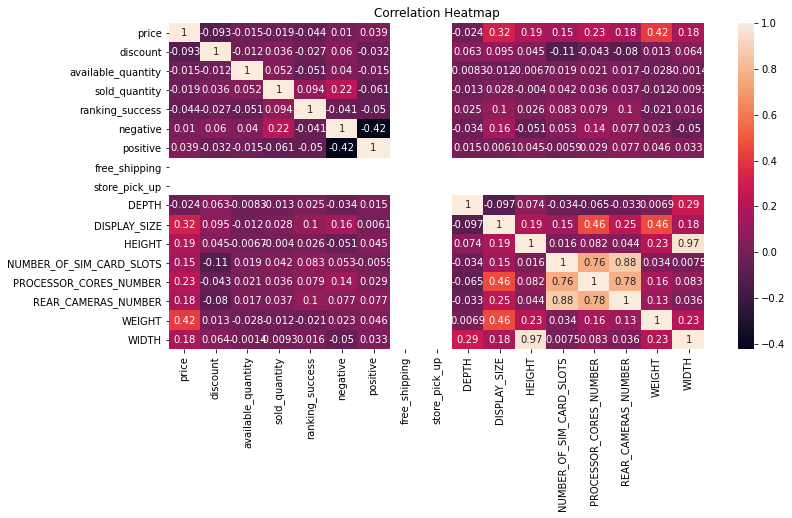

In [184]:
# graficamos un heatmap para exploras la relacion entre variables
plt.figure(figsize=(12,6))
# para no incorporar solamente aquellas variables numericas, ya que de lo contrario me tomaria los buleanos 
num_cols = [x for x in data_cell_ext.select_dtypes(include=['number']).columns]
sns.heatmap(data_cell_ext[num_cols].corr(),annot=True)
plt.title("Correlation Heatmap")
plt.show()

In [185]:
data_cell_ext['free_shipping']=data_cell_ext['free_shipping'].astype('category')
data_cell_ext['store_pick_up']=data_cell_ext['store_pick_up'].astype('category')
data_cell_ext['free_shipping']=data_cell_ext['free_shipping'].apply(lambda x: 1 if x == 'True' else 0)
data_cell_ext['store_pick_up']=data_cell_ext['store_pick_up'].apply(lambda x: 1 if x == 'True' else 0)

In [186]:
X=data_cell_ext[[x for x in data_cell_ext.columns if x !='sold_quantity']]
y=data_cell_ext['sold_quantity']

# split usando una relación de 80% de datos para train, y 20% datos para test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [187]:
# armo las listas de variables categorias y numericas
num_features = [x for x in X.select_dtypes(include=['number']).columns]
cat_features = [x for x in X.columns if x not in num_features]
print('Variables categoricas: %s' %cat_features)
print('--------------------------------------------------')
print('Variables numericas: %s' %num_features)

Variables categoricas: ['listing_type_id', 'condition', 'tags', 'state_name', 'city_name', 'power_seller_status', 'level_id', 'free_shipping', 'store_pick_up', 'BATTERY_CAPACITY', 'BRAND', 'CARRIER', 'INTERNAL_MEMORY', 'IS_DUAL_SIM', 'ITEM_CONDITION', 'MAIN_FRONT_CAMERA_RESOLUTION', 'MAIN_REAR_CAMERA_RESOLUTION', 'OPERATING_SYSTEM_NAME', 'RAM', 'WITH_BLUETOOTH', 'WITH_CAMERA', 'WITH_GPS', 'WITH_IMEI', 'WITH_PHYSICAL_QWERTY_KEYBOARD', 'WITH_TOUCHSCREEN_DISPLAY', 'WITH_USB_CONNECTOR', 'WITH_WIFI']
--------------------------------------------------
Variables numericas: ['price', 'discount', 'available_quantity', 'ranking_success', 'negative', 'positive', 'DEPTH', 'DISPLAY_SIZE', 'HEIGHT', 'NUMBER_OF_SIM_CARD_SLOTS', 'PROCESSOR_CORES_NUMBER', 'REAR_CAMERAS_NUMBER', 'WEIGHT', 'WIDTH']


In [188]:
# vamos a tener un tratamiento especial para tag
cat_features.remove('tags')
print('Variables categoricas: %s' %cat_features)

Variables categoricas: ['listing_type_id', 'condition', 'state_name', 'city_name', 'power_seller_status', 'level_id', 'free_shipping', 'store_pick_up', 'BATTERY_CAPACITY', 'BRAND', 'CARRIER', 'INTERNAL_MEMORY', 'IS_DUAL_SIM', 'ITEM_CONDITION', 'MAIN_FRONT_CAMERA_RESOLUTION', 'MAIN_REAR_CAMERA_RESOLUTION', 'OPERATING_SYSTEM_NAME', 'RAM', 'WITH_BLUETOOTH', 'WITH_CAMERA', 'WITH_GPS', 'WITH_IMEI', 'WITH_PHYSICAL_QWERTY_KEYBOARD', 'WITH_TOUCHSCREEN_DISPLAY', 'WITH_USB_CONNECTOR', 'WITH_WIFI']


In [189]:
# stop_words=stop_words_m  no voy a sacar el ahora 12
vectorizer=TfidfVectorizer(lowercase=True,strip_accents='unicode',max_df=0.7)
vectorizer.fit(X_train['tags'])

TfidfVectorizer(max_df=0.7, strip_accents='unicode')

In [190]:
X_train_tags = pd.DataFrame(vectorizer.transform(X_train['tags']).todense() )
X_test_tags = pd.DataFrame(vectorizer.transform(X_test['tags']).todense() )

# tengo que dropear 'tags' y resetear los indices
X_train.drop(['tags'],axis =1, inplace = True)
X_test.drop(['tags'],axis =1, inplace = True)

X_train.reset_index(drop = True, inplace = True)
X_test.reset_index(drop = True, inplace = True)

In [191]:
# tambien lo aplico  a y
y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

In [196]:
X_test[cat_features]

,listing_type_id,condition,state_name,city_name,power_seller_status,level_id,free_shipping,store_pick_up,BATTERY_CAPACITY,BRAND,...,OPERATING_SYSTEM_NAME,RAM,WITH_BLUETOOTH,WITH_CAMERA,WITH_GPS,WITH_IMEI,WITH_PHYSICAL_QWERTY_KEYBOARD,WITH_TOUCHSCREEN_DISPLAY,WITH_USB_CONNECTOR,WITH_WIFI
0,gold_special,new,Capital Federal,Monte Castro,platinum,5_green,0,0,4800 mAh,Kodak,...,Android,2 GB,Sí,Sí,Sí,Sí,No,Sí,Sí,Sí
1,gold_special,new,Buenos Aires,Béccar,platinum,5_green,0,0,3000 mAh,Samsung,...,Android,1 GB,Sí,Sí,Sí,Sí,No,Sí,Sí,Sí
2,gold_special,new,Misiones,Posadas,platinum,5_green,0,0,5000 mAh,Xiaomi,...,Android,8 GB,Sí,Sí,Sí,Sí,No,Sí,Sí,Sí
3,gold_pro,new,Buenos Aires,Béccar,platinum,5_green,0,0,5000 mAh,Samsung,...,Android,4 GB,Sí,Sí,Sí,Sí,No,Sí,Sí,Sí
4,gold_pro,new,Buenos Aires,Hurlingham,platinum,5_green,0,0,4500 mAh,Samsung,...,Android,6 GB,Sí,Sí,Sí,Sí,No,Sí,Sí,Sí
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,gold_special,new,Capital Federal,CABA,platinum,5_green,0,0,5000 mAh,Nokia,...,NE,0 MB,NE,NE,NE,Sí,NE,NE,NE,NE
151,gold_pro,new,Buenos Aires,San Isidro,platinum,5_green,0,0,5000 mAh,Samsung,...,Android,4 GB,Sí,Sí,Sí,Sí,No,Sí,Sí,Sí
152,gold_special,new,Buenos Aires,Lanus Este,platinum,5_green,0,0,5000 mAh,ZTE,...,Android,4 GB,Sí,Sí,Sí,Sí,No,Sí,Sí,Sí
153,gold_pro,new,Misiones,Posadas,platinum,5_green,0,0,820 mAh,BLU,...,NE,32 MB,Sí,Sí,No,Sí,NE,NE,NE,NE


In [195]:
X_train[cat_features]

,listing_type_id,condition,state_name,city_name,power_seller_status,level_id,free_shipping,store_pick_up,BATTERY_CAPACITY,BRAND,...,OPERATING_SYSTEM_NAME,RAM,WITH_BLUETOOTH,WITH_CAMERA,WITH_GPS,WITH_IMEI,WITH_PHYSICAL_QWERTY_KEYBOARD,WITH_TOUCHSCREEN_DISPLAY,WITH_USB_CONNECTOR,WITH_WIFI
0,gold_special,new,Capital Federal,Ciudad Autonoma de Buenos aires,platinum,5_green,0,0,5000 mAh,Samsung,...,Android,4 GB,Sí,Sí,Sí,Sí,No,Sí,Sí,Sí
1,gold_pro,new,Capital Federal,Parque Patricios,platinum,5_green,0,0,3500 mAh,LG,...,Android,3 GB,Sí,Sí,Sí,Sí,No,Sí,Sí,Sí
2,gold_pro,new,Córdoba,Córdoba,platinum,5_green,0,0,4000 mAh,Alcatel,...,NE,3 GB,NE,Sí,NE,Sí,NE,NE,NE,NE
3,gold_pro,new,Capital Federal,Monte Castro,platinum,5_green,0,0,4000 mAh,TCL,...,Android,2 GB,Sí,Sí,Sí,Sí,No,Sí,NE,Sí
4,gold_special,new,Capital Federal,Núñez,platinum,5_green,0,0,3430 mAh,Sony,...,Android,3 GB,Sí,Sí,Sí,Sí,No,Sí,Sí,Sí
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,gold_special,new,Capital Federal,Once,platinum,5_green,0,0,4000 mAh,Motorola,...,Android,2 GB,Sí,Sí,Sí,Sí,No,Sí,Sí,Sí
613,gold_pro,new,Capital Federal,Once,platinum,5_green,0,0,5000 mAh,TCL,...,NE,3 GB,Sí,NE,NE,Sí,NE,NE,NE,NE
614,gold_pro,new,Capital Federal,Núñez,platinum,5_green,0,0,5000 mAh,Samsung,...,Android,3 GB,Sí,Sí,Sí,Sí,No,Sí,Sí,Sí
615,gold_special,new,Capital Federal,Villa Urquiza,platinum,5_green,0,0,5000 mAh,Samsung,...,Android,4 GB,Sí,Sí,Sí,Sí,No,Sí,Sí,Sí


In [199]:
# con OneHotEncoder creamos variables dummies para place_name
onehot_encoder2 = OneHotEncoder(sparse=False,handle_unknown='ignore')

#X train enconded
X_ohe_train = onehot_encoder2.fit_transform(X_train[cat_features])
X_ohe_train = pd.DataFrame(X_ohe_train, columns = onehot_encoder2.get_feature_names(cat_features))

#X test enconded
X_ohe_test = onehot_encoder2.transform(X_test[cat_features])
X_ohe_test = pd.DataFrame(X_ohe_test, columns = onehot_encoder2.get_feature_names(cat_features))

In [200]:
# normalization of X_train
min_max_scaler = preprocessing.MinMaxScaler()
X_train_scaled = min_max_scaler.fit_transform(X_train[num_features])
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_features)

# normalization of X_test
X_test_scaled = min_max_scaler.transform(X_test[num_features])
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_features)

In [201]:
print('Sizes de los distintos datasets de entrenamiento y testeo')
print('Train Tags Vectorizado: ',X_train_tags.shape)
print('Train Tags Vectorizado: ', X_test_tags.shape)
print('--------------------------------------------------')
print('Train OHE: ' ,X_ohe_train.shape)
print('Test OHE: ', X_ohe_test.shape)
print('--------------------------------------------------')
print('Train Scaled: ',X_train_scaled.shape)
print('Test Scaled: ', X_test_scaled.shape)

Sizes de los distintos datasets de entrenamiento y testeo
Train Tags Vectorizado:  (617, 19)
Train Tags Vectorizado:  (155, 19)
--------------------------------------------------
Train OHE:  (617, 308)
Test OHE:  (155, 308)
--------------------------------------------------
Train Scaled:  (617, 14)
Test Scaled:  (155, 14)


In [202]:
# concatenamos los datasets obtenidos hasta el momento
X_train = pd.concat([X_train_scaled, X_ohe_train , X_train_tags], axis = 1)
X_test = pd.concat([X_test_scaled, X_ohe_test, X_test_tags], axis = 1)

In [203]:
# luego de la unificacion
display(X_train.shape)
display(X_test.shape)
display(y_train.shape)
display(y_test.shape)

(617, 341)

(155, 341)

(617,)

(155,)

In [204]:
# Instanciamos Cross Validation
cv = KFold(n_splits=5, random_state=42, shuffle=True)

# Instanciamos el modelo que vamos a entrenar
model_cbr = CatBoostRegressor()
model_comparison.loc[2,'Model'] = 'CatBoostRegressor_just_cells'

# Creamos la grilla de parametros
params = {  
      
    "depth": [5,6,7,8,9],            
    "learning_rate": [0.001, 0.01, 0.1],
    "l2_leaf_reg":[1.0,0.1]
}

# Creamos la grilla con GridSearch
cbr = GridSearchCV(model_cbr, param_grid=params, cv=cv, verbose=1, n_jobs=-1)

# Entrenamos el modelo
cbr.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 16.0min finished


0:	learn: 584.1631447	total: 12.4ms	remaining: 12.4s
1:	learn: 540.7419013	total: 18.4ms	remaining: 9.16s
2:	learn: 495.5616973	total: 25ms	remaining: 8.32s
3:	learn: 460.0873561	total: 31.4ms	remaining: 7.81s
4:	learn: 421.1354820	total: 37.6ms	remaining: 7.48s
5:	learn: 391.9386862	total: 45.2ms	remaining: 7.49s
6:	learn: 364.8946000	total: 51.9ms	remaining: 7.36s
7:	learn: 340.0811107	total: 60.5ms	remaining: 7.5s
8:	learn: 314.3451720	total: 66.3ms	remaining: 7.3s
9:	learn: 290.7249204	total: 71.9ms	remaining: 7.12s
10:	learn: 267.8836667	total: 81.4ms	remaining: 7.32s
11:	learn: 253.3782119	total: 88.5ms	remaining: 7.29s
12:	learn: 241.1270374	total: 94ms	remaining: 7.14s
13:	learn: 225.7907877	total: 99.8ms	remaining: 7.03s
14:	learn: 211.8855477	total: 105ms	remaining: 6.91s
15:	learn: 196.6728755	total: 111ms	remaining: 6.81s
16:	learn: 183.7757452	total: 116ms	remaining: 6.73s
17:	learn: 171.4808143	total: 122ms	remaining: 6.65s
18:	learn: 161.3948124	total: 127ms	remaining: 6

161:	learn: 26.6784721	total: 1.1s	remaining: 5.72s
162:	learn: 26.5993090	total: 1.11s	remaining: 5.71s
163:	learn: 26.4894195	total: 1.12s	remaining: 5.7s
164:	learn: 26.2746001	total: 1.12s	remaining: 5.69s
165:	learn: 26.2402587	total: 1.13s	remaining: 5.68s
166:	learn: 26.2171301	total: 1.14s	remaining: 5.67s
167:	learn: 26.1644074	total: 1.14s	remaining: 5.67s
168:	learn: 25.9473288	total: 1.15s	remaining: 5.65s
169:	learn: 25.8117770	total: 1.16s	remaining: 5.64s
170:	learn: 25.7189637	total: 1.16s	remaining: 5.63s
171:	learn: 25.6538624	total: 1.17s	remaining: 5.61s
172:	learn: 25.5515796	total: 1.17s	remaining: 5.6s
173:	learn: 25.4060597	total: 1.18s	remaining: 5.58s
174:	learn: 25.1167509	total: 1.18s	remaining: 5.57s
175:	learn: 24.9826343	total: 1.19s	remaining: 5.56s
176:	learn: 24.9412319	total: 1.19s	remaining: 5.54s
177:	learn: 24.8658095	total: 1.2s	remaining: 5.55s
178:	learn: 24.7573771	total: 1.21s	remaining: 5.54s
179:	learn: 24.7361018	total: 1.21s	remaining: 5.5

345:	learn: 17.1415107	total: 2.19s	remaining: 4.13s
346:	learn: 17.1267127	total: 2.19s	remaining: 4.12s
347:	learn: 17.1076822	total: 2.2s	remaining: 4.12s
348:	learn: 17.0912902	total: 2.2s	remaining: 4.11s
349:	learn: 17.0844501	total: 2.21s	remaining: 4.1s
350:	learn: 17.0679092	total: 2.21s	remaining: 4.1s
351:	learn: 17.0599067	total: 2.25s	remaining: 4.15s
352:	learn: 17.0212138	total: 2.26s	remaining: 4.14s
353:	learn: 17.0195043	total: 2.26s	remaining: 4.13s
354:	learn: 17.0126983	total: 2.27s	remaining: 4.12s
355:	learn: 17.0005978	total: 2.27s	remaining: 4.12s
356:	learn: 16.9876229	total: 2.28s	remaining: 4.11s
357:	learn: 16.9632692	total: 2.3s	remaining: 4.13s
358:	learn: 16.9433686	total: 2.31s	remaining: 4.12s
359:	learn: 16.9243867	total: 2.31s	remaining: 4.11s
360:	learn: 16.8937433	total: 2.32s	remaining: 4.1s
361:	learn: 16.8873610	total: 2.32s	remaining: 4.09s
362:	learn: 16.8734295	total: 2.33s	remaining: 4.08s
363:	learn: 16.8538810	total: 2.33s	remaining: 4.08s

524:	learn: 15.5172366	total: 3.26s	remaining: 2.95s
525:	learn: 15.5087294	total: 3.26s	remaining: 2.94s
526:	learn: 15.5052514	total: 3.27s	remaining: 2.93s
527:	learn: 15.5048345	total: 3.28s	remaining: 2.93s
528:	learn: 15.5003071	total: 3.28s	remaining: 2.92s
529:	learn: 15.4969272	total: 3.29s	remaining: 2.91s
530:	learn: 15.4909759	total: 3.29s	remaining: 2.91s
531:	learn: 15.4848624	total: 3.31s	remaining: 2.91s
532:	learn: 15.4817848	total: 3.31s	remaining: 2.9s
533:	learn: 15.4793120	total: 3.32s	remaining: 2.9s
534:	learn: 15.4763617	total: 3.33s	remaining: 2.89s
535:	learn: 15.4706243	total: 3.33s	remaining: 2.88s
536:	learn: 15.4681105	total: 3.33s	remaining: 2.88s
537:	learn: 15.4623015	total: 3.36s	remaining: 2.88s
538:	learn: 15.4550280	total: 3.37s	remaining: 2.88s
539:	learn: 15.4521350	total: 3.38s	remaining: 2.88s
540:	learn: 15.4437139	total: 3.39s	remaining: 2.87s
541:	learn: 15.4410851	total: 3.39s	remaining: 2.87s
542:	learn: 15.4404178	total: 3.4s	remaining: 2.

703:	learn: 15.1415929	total: 4.34s	remaining: 1.82s
704:	learn: 15.1405628	total: 4.34s	remaining: 1.82s
705:	learn: 15.1396017	total: 4.35s	remaining: 1.81s
706:	learn: 15.1388189	total: 4.36s	remaining: 1.8s
707:	learn: 15.1385683	total: 4.36s	remaining: 1.8s
708:	learn: 15.1380266	total: 4.37s	remaining: 1.79s
709:	learn: 15.1363044	total: 4.38s	remaining: 1.79s
710:	learn: 15.1360678	total: 4.38s	remaining: 1.78s
711:	learn: 15.1358888	total: 4.39s	remaining: 1.77s
712:	learn: 15.1348811	total: 4.39s	remaining: 1.77s
713:	learn: 15.1339579	total: 4.4s	remaining: 1.76s
714:	learn: 15.1333890	total: 4.41s	remaining: 1.75s
715:	learn: 15.1326394	total: 4.41s	remaining: 1.75s
716:	learn: 15.1319662	total: 4.42s	remaining: 1.74s
717:	learn: 15.1313835	total: 4.42s	remaining: 1.74s
718:	learn: 15.1311108	total: 4.43s	remaining: 1.73s
719:	learn: 15.1308701	total: 4.43s	remaining: 1.72s
720:	learn: 15.1303208	total: 4.44s	remaining: 1.72s
721:	learn: 15.1301356	total: 4.44s	remaining: 1.

878:	learn: 15.0554080	total: 5.41s	remaining: 744ms
879:	learn: 15.0549867	total: 5.41s	remaining: 738ms
880:	learn: 15.0544756	total: 5.42s	remaining: 732ms
881:	learn: 15.0540004	total: 5.43s	remaining: 726ms
882:	learn: 15.0537282	total: 5.43s	remaining: 720ms
883:	learn: 15.0534577	total: 5.44s	remaining: 713ms
884:	learn: 15.0534086	total: 5.44s	remaining: 707ms
885:	learn: 15.0530265	total: 5.45s	remaining: 701ms
886:	learn: 15.0529696	total: 5.45s	remaining: 695ms
887:	learn: 15.0524176	total: 5.46s	remaining: 688ms
888:	learn: 15.0523238	total: 5.46s	remaining: 682ms
889:	learn: 15.0522953	total: 5.47s	remaining: 676ms
890:	learn: 15.0518140	total: 5.47s	remaining: 670ms
891:	learn: 15.0514644	total: 5.48s	remaining: 663ms
892:	learn: 15.0514162	total: 5.48s	remaining: 657ms
893:	learn: 15.0511463	total: 5.49s	remaining: 651ms
894:	learn: 15.0509447	total: 5.49s	remaining: 645ms
895:	learn: 15.0504084	total: 5.5s	remaining: 638ms
896:	learn: 15.0502681	total: 5.5s	remaining: 6

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=<catboost.core.CatBoostRegressor object at 0x000001E9018954C0>,
             n_jobs=-1,
             param_grid={'depth': [5, 6, 7, 8, 9], 'l2_leaf_reg': [1.0, 0.1],
                         'learning_rate': [0.001, 0.01, 0.1]},
             verbose=1)

In [205]:
# Mejores parametros 
print('Best parameters:  ',cbr.best_params_)

Best parameters:   {'depth': 7, 'l2_leaf_reg': 0.1, 'learning_rate': 0.1}


In [206]:
# Evaluamos el rendimiento del modelo
model_comparison.loc[2,'Train_score'] = evaluar_rendimiento(cbr.best_estimator_,"CatBoost", X_train, y_train, cv)

Rendimiento de CatBoost:	0.368 ± 0.258


In [207]:
# Calculamos las predicciones
y_pred_cbr = cbr.predict(X_test)

In [208]:
#Rendimiento del modelo con los datos de test
r2 = r2_score(y_test,y_pred_cbr)
print('r² es igual a: ', r2)
model_comparison.loc[2,'Test_score'] = r2

r² es igual a:  0.9355070085361245


<AxesSubplot:>

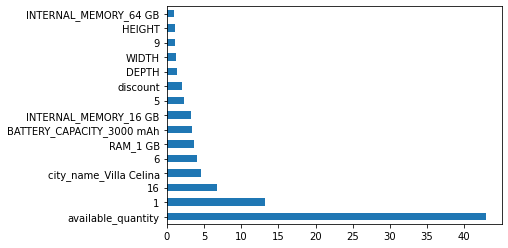

In [209]:
feat_importances = pd.Series(cbr.best_estimator_.get_feature_importance(), index=X_test.columns)
feat_importances.nlargest(15).plot(kind='barh')

Algo que estoy notando es que en el test score esta siendo superior al train score, esto quia por la regularizacion aplicada.
Por otro lado, el data set tambien es pequeño comparado con el caso anterior donde se incorporo un mayor numero de datos.
Tambien habria que revisar como es la distribucion de los datos que pueda explicar este comportamiento observado.

También juega en contra la maldicion de la dimensionalidad, ya que el número de columnas es casi del mismo orden que el numero de registros, posibllemente necesito mucha más data.

In [ ]:
# para conservarlo
#data_cell_att.to_excel('./data/data_cell_att.xlsx', index= False)
data_cell_att_minus.to_excel('./data/data_cell_att_minus.xlsx', index= False)

In [ ]:
#pip freeze > requirements.txt